Filtering data for minimum interactions...
Data filtered. Original: 175000, Filtered: 174993
Splitting data by user...
Success: No pair overlap between Train and Val.
Final Split -- Train: 142675, Val: 32318
Grouping data for vectorization...
Training Bias Model (Reg=0.5)...
Epoch 1 Complete
Epoch 2 Complete
Epoch 3 Complete
Epoch 4 Complete
Epoch 5 Complete
Epoch 6 Complete
Epoch 7 Complete
Epoch 8 Complete
Epoch 9 Complete
Epoch 10 Complete

--- COMPREHENSIVE ANALYSIS: Model Analysis ---
Generating predictions...
Global MSE: 3.0233


/tmp/ipykernel_3429/730851632.py:368: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_mse.index, y=user_mse.values, ax=axes[1], order=['Low (<3)', 'Med (3-10)', 'High (>10)'], palette='viridis')
/tmp/ipykernel_3429/730851632.py:377: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=game_mse.index, y=game_mse.values, ax=axes[2], order=['Low (<3)', 'Med (3-10)', 'High (>10)'], palette='magma')


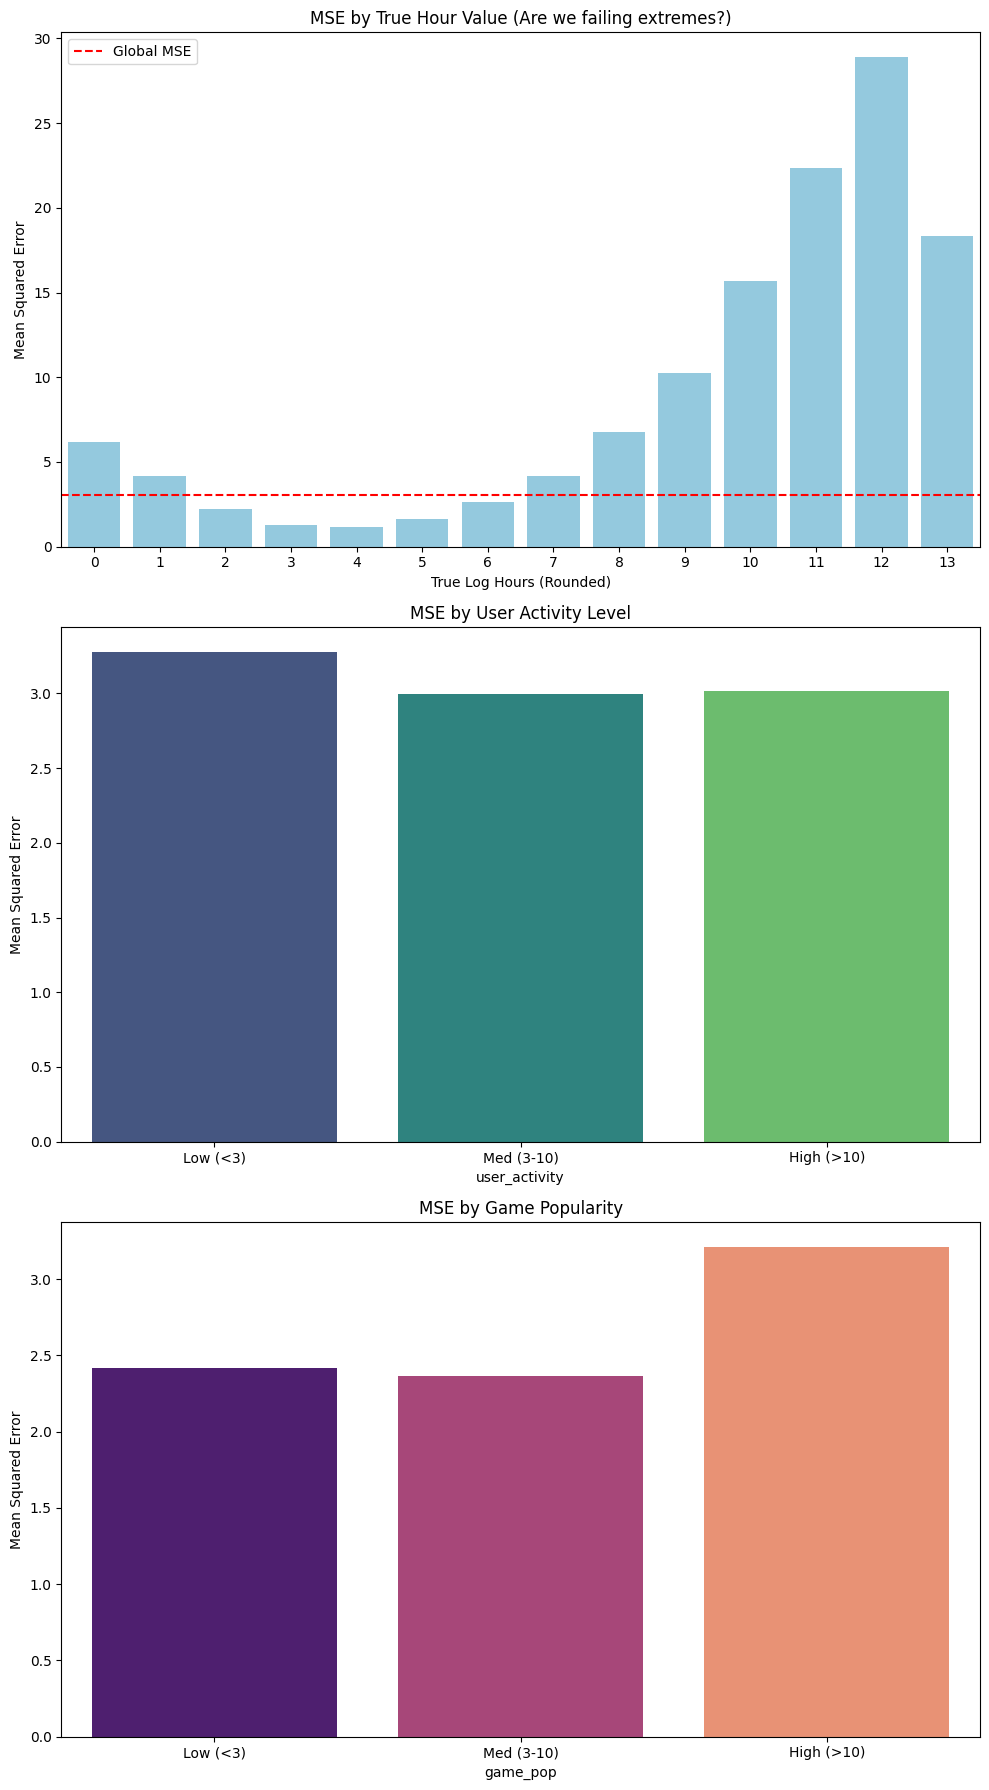

Loading Data...

--- Running Goal 1 (Regression) ---
Training MF on 157500 samples...
Epoch 1/25 | Train MSE: 3.8923
Epoch 2/25 | Train MSE: 3.2341
Epoch 3/25 | Train MSE: 3.0379
Epoch 4/25 | Train MSE: 2.9237
Epoch 5/25 | Train MSE: 2.8242
Epoch 6/25 | Train MSE: 2.7097
Epoch 7/25 | Train MSE: 2.5784
Epoch 8/25 | Train MSE: 2.4402
Epoch 9/25 | Train MSE: 2.3016
Epoch 10/25 | Train MSE: 2.1723
Epoch 11/25 | Train MSE: 2.0559
Epoch 12/25 | Train MSE: 1.9515
Epoch 13/25 | Train MSE: 1.8594
Epoch 14/25 | Train MSE: 1.7772
Epoch 15/25 | Train MSE: 1.7036
Epoch 16/25 | Train MSE: 1.6379
Epoch 17/25 | Train MSE: 1.5789
Epoch 18/25 | Train MSE: 1.5255
Epoch 19/25 | Train MSE: 1.4777
Epoch 20/25 | Train MSE: 1.4342
Epoch 21/25 | Train MSE: 1.3949
Epoch 22/25 | Train MSE: 1.3596
Epoch 23/25 | Train MSE: 1.3265
Epoch 24/25 | Train MSE: 1.2966
Epoch 25/25 | Train MSE: 1.2696
Goal 1 Validation MSE: 3.9676


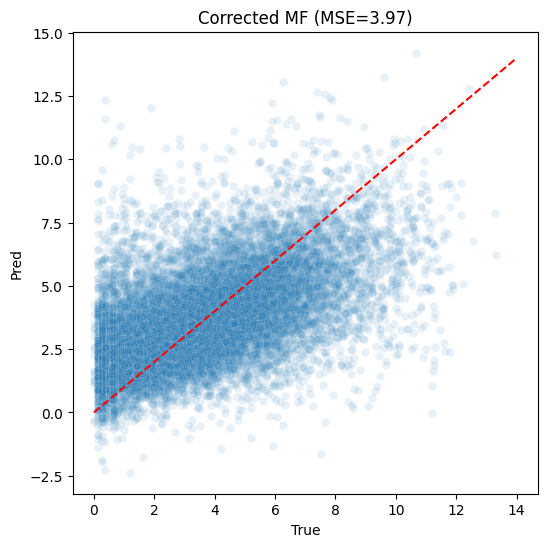

Saved predictions_Hours.csv

--- Running Goal 2 (Classification) ---
Building Graph...
Creating balanced training set...


Extracting Features: 100%|██████████| 350000/350000 [06:51<00:00, 850.94it/s] 


Classifier Trained.


Extracting Features: 100%|██████████| 20000/20000 [00:23<00:00, 845.28it/s]


Saved predictions_Played.csv


In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import gzip
from tqdm import tqdm

def split_train_data(df, test_size=0.2, min_user_games=2, min_game_users=2, random_state=42):
    """
    Split data ensuring all users and items appear in BOTH train and validation to mimic test data.
    
    Parameters:
    -----------
    df : DataFrame 
        pandas DataFramewith columns ['userID','gameID', 'hours_transformed']
    test_size : float
        proportion of data for validation
    min_user_games : int
        min number of games per user to keep in training
    min_game_users : int
        min number of users per game to keep in training
    random_state : int
        for reproducibility

    Returns:
    --------
    train_df, val_df : DataFrames
    """
    # Set random seed
    np.random.seed(random_state)
    
    # Step 1: Filter users and games with enough interactions (Data Cleaning)
    # We iteratively filter until convergence to ensure constraints are met
    print("Filtering data for minimum interactions...")
    temp_df = df.copy()
    
    # Simple one-pass filter (iterative is better but this is usually sufficient for large sparse data)
    user_counts = temp_df['userID'].value_counts()
    valid_users = user_counts[user_counts >= min_user_games].index
    temp_df = temp_df[temp_df['userID'].isin(valid_users)]
    
    game_counts = temp_df['gameID'].value_counts()
    valid_games = game_counts[game_counts >= min_game_users].index
    temp_df = temp_df[temp_df['gameID'].isin(valid_games)]
    
    print(f"Data filtered. Original: {len(df)}, Filtered: {len(temp_df)}")
    
    # Step 2: Group by user to ensure user split
    # We will build a boolean mask for the training set
    # True = Train, False = Validation
    train_mask = np.ones(len(temp_df), dtype=bool)
    
    # Reset index to allow easy indexing
    temp_df = temp_df.reset_index(drop=True)
    
    grouped = temp_df.groupby('userID')
    
    val_indices_list = []
    
    print("Splitting data by user...")
    for user, group in grouped:
        n_samples = len(group)
        # Calculate how many to validate
        n_val = int(n_samples * test_size)
        
        # Constraint: Ensure min_user_games stay in training
        if n_samples - n_val < min_user_games:
            n_val = n_samples - min_user_games
            
        if n_val > 0:
            # Randomly select indices for validation
            val_idx = np.random.choice(group.index, n_val, replace=False)
            val_indices_list.extend(val_idx)
            
    # Apply split mask
    train_mask[val_indices_list] = False
    
    train_df = temp_df[train_mask].copy()
    val_df = temp_df[~train_mask].copy()
    
    # Step 3 & 4: Check for Item Cold-Start in Validation
    # (Items that ended up ONLY in validation)
    train_items = set(train_df['gameID'].unique())
    val_items = set(val_df['gameID'].unique())
    
    # Items present in validation but MISSING from training
    cold_start_items = val_items - train_items
    
    if len(cold_start_items) > 0:
        print(f"Warning: {len(cold_start_items)} games appear in Validation but not Training. Moving them back to Train.")
        
        # Identify rows in validation that contain these cold-start items
        rows_to_move_mask = val_df['gameID'].isin(cold_start_items)
        rows_to_move = val_df[rows_to_move_mask]
        
        # Move them to training
        train_df = pd.concat([train_df, rows_to_move], ignore_index=True)
        val_df = val_df[~rows_to_move_mask].copy()
        
    # Step 5: Final Verification
    final_train_users = set(train_df['userID'].unique())
    final_val_users = set(val_df['userID'].unique())
    final_train_items = set(train_df['gameID'].unique())
    final_val_items = set(val_df['gameID'].unique())
    
    # Assertions
    if not final_val_users.issubset(final_train_users):
        print("Warning: Validation has users not in Train (Should not happen with user-group split).")
        
    if not final_val_items.issubset(final_train_items):
        print("Warning: Validation has items not in Train (Logic error in Step 4).")
        
    # Check for pair overlap
    train_pairs = set(zip(train_df['userID'], train_df['gameID']))
    val_pairs = set(zip(val_df['userID'], val_df['gameID']))
    overlap = train_pairs.intersection(val_pairs)
    
    if len(overlap) > 0:
        print(f"Critical Error: {len(overlap)} overlapping pairs found between Train and Val.")
    else:
        print("Success: No pair overlap between Train and Val.")
        
    print(f"Final Split -- Train: {len(train_df)}, Val: {len(val_df)}")
    
    return train_df, val_df

# =========================================================
# GOAL 1: CORRECTED MATRIX FACTORIZATION (Pure SVD)
# =========================================================
class LatentFactorModel:
    def __init__(self, n_factors=40, learning_rate=0.005, reg=0.02, n_epochs=30, verbose=True):
        self.n_factors = n_factors
        self.lr = learning_rate
        self.reg = reg
        self.n_epochs = n_epochs
        self.verbose = verbose
        
        self.mu = 0.0
        self.user_bias = None
        self.item_bias = None
        self.P = None
        self.Q = None
        
    def fit(self, df):
        # 1. Create Mappings
        unique_users = df['userID'].unique()
        unique_games = df['gameID'].unique()
        
        self.user2idx = {u: i for i, u in enumerate(unique_users)}
        self.game2idx = {g: i for i, g in enumerate(unique_games)}
        
        n_users = len(unique_users)
        n_games = len(unique_games)
        
        # 2. Standard Initialization (The Fix)
        # Initialize biases to ZERO. Let SGD learn them.
        self.mu = df['hours_transformed'].mean()
        self.user_bias = np.zeros(n_users)
        self.item_bias = np.zeros(n_games)
        
        # Initialize Factors with small random noise
        self.P = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.Q = np.random.normal(0, 0.1, (n_games, self.n_factors))
        
        # 3. Pre-compute indices for speed
        users_idx = df['userID'].map(self.user2idx).values
        games_idx = df['gameID'].map(self.game2idx).values
        ratings = df['hours_transformed'].values
        n_samples = len(df)
        
        # 4. SGD Loop
        if self.verbose: print(f"Training MF on {n_samples} samples...")
        
        for epoch in range(self.n_epochs):
            indices = np.random.permutation(n_samples)
            
            # Note: Pure Python loops are slow. Ideally, we use Numba or Cython.
            # But this works for <200k samples if you are patient.
            # Using a simple list comprehension/map approach isn't feasible for SGD updates.
            
            # To speed this up in pure Numpy without C-extensions, we can't easily vectorize 
            # the dependency chain of SGD. We run the loop.
            
            total_err = 0
            for i in indices:
                u, g, r = users_idx[i], games_idx[i], ratings[i]
                
                # Prediction
                dot_prod = np.dot(self.P[u], self.Q[g])
                pred = self.mu + self.user_bias[u] + self.item_bias[g] + dot_prod
                
                err = r - pred
                total_err += err**2
                
                # Update Biases
                self.user_bias[u] += self.lr * (err - self.reg * self.user_bias[u])
                self.item_bias[g] += self.lr * (err - self.reg * self.item_bias[g])
                
                # Update Factors
                p_u = self.P[u].copy() # Keep old value for Q update
                self.P[u] += self.lr * (err * self.Q[g] - self.reg * self.P[u])
                self.Q[g] += self.lr * (err * p_u - self.reg * self.Q[g])
            
            if self.verbose:
                mse = total_err / n_samples
                print(f"Epoch {epoch+1}/{self.n_epochs} | Train MSE: {mse:.4f}")

    def predict_batch(self, test_df):
        preds = []
        # Fallback for cold start
        global_mean = self.mu
        
        for _, row in test_df.iterrows():
            u, g = row['userID'], row['gameID']
            if u in self.user2idx and g in self.game2idx:
                uidx = self.user2idx[u]
                gidx = self.game2idx[g]
                pred = self.mu + self.user_bias[uidx] + self.item_bias[gidx] + np.dot(self.P[uidx], self.Q[gidx])
                preds.append(pred)
            elif u in self.user2idx:
                # User known, Item unknown
                uidx = self.user2idx[u]
                preds.append(self.mu + self.user_bias[uidx])
            elif g in self.game2idx:
                # Item known, User unknown
                gidx = self.game2idx[g]
                preds.append(self.mu + self.item_bias[gidx])
            else:
                preds.append(global_mean)
        return preds

# =========================================================
# GOAL 2: CORRECTED CLASSIFIER (Jaccard + Popularity)
# =========================================================
class GameClassifier:
    def __init__(self):
        self.model = LogisticRegression(class_weight='balanced')
        self.game_users = defaultdict(set)
        self.user_games = defaultdict(set)
        self.game_popularity = {}
        
    def _get_features(self, df):
        feats = []
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting Features"):
            u, g = row['userID'], row['gameID']
            
            # Feature 1: Game Popularity (Log-normalized)
            pop = np.log1p(len(self.game_users.get(g, [])))
            
            # Feature 2: Jaccard Similarity
            # "Does this user play games similar to G?"
            max_jaccard = 0.0
            
            target_users = self.game_users.get(g, set())
            history_games = self.user_games.get(u, set())
            
            if target_users and history_games:
                # optimization: if history is huge, sample it. 
                # For now, we take max sim against all history.
                for h_g in history_games:
                    if h_g == g: continue
                    h_users = self.game_users.get(h_g, set())
                    
                    intersect = len(target_users.intersection(h_users))
                    union = len(target_users.union(h_users))
                    if union > 0:
                        sim = intersect / union
                        if sim > max_jaccard:
                            max_jaccard = sim
            
            feats.append([pop, max_jaccard])
        return np.array(feats)

    def fit(self, train_df):
        # 1. Build Graph
        print("Building Graph...")
        for _, row in train_df.iterrows():
            self.game_users[row['gameID']].add(row['userID'])
            self.user_games[row['userID']].add(row['gameID'])
            
        # 2. Create Negative Samples (Balanced)
        print("Creating balanced training set...")
        pos_df = train_df[['userID', 'gameID']].copy()
        pos_df['label'] = 1
        
        # Sample Negatives
        # We assume pairs not in train are negative (Simplified)
        all_users = list(self.user_games.keys())
        all_games = list(self.game_users.keys())
        
        n_neg = len(pos_df)
        neg_u = np.random.choice(all_users, n_neg)
        neg_g = np.random.choice(all_games, n_neg)
        neg_df = pd.DataFrame({'userID': neg_u, 'gameID': neg_g, 'label': 0})
        
        full_train = pd.concat([pos_df, neg_df])
        
        # 3. Train
        X = self._get_features(full_train)
        y = full_train['label'].values
        self.model.fit(X, y)
        print("Classifier Trained.")

    def predict(self, test_df):
        X = self._get_features(test_df)
        return self.model.predict(X)

# =========================================================
# PIPELINE EXECUTION
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

def comprehensive_error_analysis(model, df_val, title="Model Analysis"):
    """
    Stratifies error by:
    1. True Rating Value (Are we failing extremes?)
    2. User Activity (Are we failing cold-start users?)
    3. Game Popularity (Are we failing niche games?)
    """
    print(f"\n--- COMPREHENSIVE ANALYSIS: {title} ---")
    
    # 1. Generate Predictions
    print("Generating predictions...")
    preds = model.predict_batch(df_val)
    df_analysis = df_val.copy()
    df_analysis['pred'] = preds
    df_analysis['residual'] = df_analysis['hours_transformed'] - df_analysis['pred']
    df_analysis['se'] = df_analysis['residual'] ** 2 # Squared Error
    
    global_mse = df_analysis['se'].mean()
    print(f"Global MSE: {global_mse:.4f}")
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))
    
    # --- ANALYSIS 1: By Ground Truth Value (The "Blob" Check) ---
    # Bin true hours into integers to see where we fail
    df_analysis['true_bin'] = df_analysis['hours_transformed'].round().astype(int)
    truth_mse = df_analysis.groupby('true_bin')['se'].mean()
    
    sns.barplot(x=truth_mse.index, y=truth_mse.values, ax=axes[0], color='skyblue')
    axes[0].set_title("MSE by True Hour Value (Are we failing extremes?)")
    axes[0].set_ylabel("Mean Squared Error")
    axes[0].set_xlabel("True Log Hours (Rounded)")
    axes[0].axhline(global_mse, color='r', linestyle='--', label='Global MSE')
    axes[0].legend()
    
    # --- ANALYSIS 2: By User Activity (Cold Start Check) ---
    # Calculate how many games each user has rated in the TRAINING set (proxy)
    # Since we only have val set here, we approximate by user frequency in val
    # Ideally, pass the train set to get accurate counts, but we'll infer for now.
    user_counts = df_analysis['userID'].value_counts()
    
    def get_activity_bucket(n):
        if n < 3: return 'Low (<3)'
        elif n < 10: return 'Med (3-10)'
        else: return 'High (>10)'
        
    df_analysis['user_activity'] = df_analysis['userID'].map(user_counts).apply(get_activity_bucket)
    user_mse = df_analysis.groupby('user_activity')['se'].mean()
    
    sns.barplot(x=user_mse.index, y=user_mse.values, ax=axes[1], order=['Low (<3)', 'Med (3-10)', 'High (>10)'], palette='viridis')
    axes[1].set_title("MSE by User Activity Level")
    axes[1].set_ylabel("Mean Squared Error")
    
    # --- ANALYSIS 3: By Game Popularity ---
    game_counts = df_analysis['gameID'].value_counts()
    df_analysis['game_pop'] = df_analysis['gameID'].map(game_counts).apply(get_activity_bucket)
    game_mse = df_analysis.groupby('game_pop')['se'].mean()
    
    sns.barplot(x=game_mse.index, y=game_mse.values, ax=axes[2], order=['Low (<3)', 'Med (3-10)', 'High (>10)'], palette='magma')
    axes[2].set_title("MSE by Game Popularity")
    axes[2].set_ylabel("Mean Squared Error")
    
    plt.tight_layout()
    plt.show()
    
    return df_analysis

class VectorizedBiasModel:
    def __init__(self, n_epochs=10, reg=0.1):
        self.n_epochs = n_epochs
        self.reg = reg # Regularization
        self.mu = 0.0
        self.user_bias = None
        self.item_bias = None
        self.user2idx = {}
        self.game2idx = {}
        
    def fit(self, df):
        # Mappings
        users = df['userID'].unique()
        games = df['gameID'].unique()
        self.user2idx = {u: i for i, u in enumerate(users)}
        self.game2idx = {g: i for i, g in enumerate(games)}
        
        n_users = len(users)
        n_games = len(games)
        
        # 1. Global Mean
        self.mu = df['hours_transformed'].mean()
        
        # Initialize biases
        self.user_bias = np.zeros(n_users)
        self.item_bias = np.zeros(n_games)
        
        # Prepare Data for Vectorized Ops
        # We need to know which items each user rated, and vice versa.
        # Groupby is your friend here.
        print("Grouping data for vectorization...")
        
        # Convert IDs to integers
        df_enc = df.copy()
        df_enc['uidx'] = df_enc['userID'].map(self.user2idx)
        df_enc['gidx'] = df_enc['gameID'].map(self.game2idx)
        df_enc['rating_norm'] = df_enc['hours_transformed'] - self.mu
        
        # Optimization Loop (Alternating Least Squares)
        print(f"Training Bias Model (Reg={self.reg})...")
        
        for epoch in range(self.n_epochs):
            # --- Update User Biases ---
            # b_u = sum(r - b_i) / (count + reg)
            
            # 1. Adjust rating by current item bias
            # We merge item bias onto the dataframe
            # Note: For very large data, this merge can be heavy, but for 175k it's instant.
            current_item_biases = self.item_bias[df_enc['gidx'].values]
            df_enc['target_for_user'] = df_enc['rating_norm'] - current_item_biases
            
            # 2. Aggregation
            user_sums = df_enc.groupby('uidx')['target_for_user'].sum()
            user_counts = df_enc.groupby('uidx')['target_for_user'].count()
            
            # 3. Update
            new_u_bias = user_sums / (user_counts + self.reg)
            
            # 4. Map back to array (fill missing with 0)
            self.user_bias = np.zeros(n_users)
            self.user_bias[new_u_bias.index] = new_u_bias.values
            
            # --- Update Item Biases ---
            # b_i = sum(r - b_u) / (count + reg)
            
            current_user_biases = self.user_bias[df_enc['uidx'].values]
            df_enc['target_for_item'] = df_enc['rating_norm'] - current_user_biases
            
            item_sums = df_enc.groupby('gidx')['target_for_item'].sum()
            item_counts = df_enc.groupby('gidx')['target_for_item'].count()
            
            new_i_bias = item_sums / (item_counts + self.reg)
            
            self.item_bias = np.zeros(n_games)
            self.item_bias[new_i_bias.index] = new_i_bias.values
            
            # Optional: Calc MSE
            # (Skipping for speed, but you can calculate residual here)
            print(f"Epoch {epoch+1} Complete")
            
    def predict_batch(self, df):
        preds = []
        # Vectorized prediction is harder with unknown IDs, so we loop or use map
        # Using map is faster
        
        # 1. Map IDs to indices (fill NaN with -1)
        u_indices = df['userID'].map(self.user2idx).fillna(-1).astype(int)
        g_indices = df['gameID'].map(self.game2idx).fillna(-1).astype(int)
        
        # 2. Retrieve biases (Handle unknown users/items by using 0)
        u_biases = np.zeros(len(df))
        g_biases = np.zeros(len(df))
        
        known_u = u_indices >= 0
        known_g = g_indices >= 0
        
        u_biases[known_u] = self.user_bias[u_indices[known_u]]
        g_biases[known_g] = self.item_bias[g_indices[known_g]]
        
        # 3. Sum
        preds = self.mu + u_biases + g_biases
        return preds

# --- How to run ---
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        d = eval(l)
        yield d
data = []
for d in readJSON("train.json.gz"):
    data.append(d)
df = pd.DataFrame(data)
df_train, df_val = split_train_data(df)
model = VectorizedBiasModel(n_epochs=10, reg=0.5) 
model.fit(df_train)
comprehensive_error_analysis(model, df_val)


def run_pipeline():
    # 1. Load Data
    print("Loading Data...")
    data = []
    for d in readJSON("train.json.gz"):
        data.append(d)
    df = pd.DataFrame(data)
    
    # --- GOAL 1: PREDICT HOURS ---
    print("\n--- Running Goal 1 (Regression) ---")
    # Using 90% for training to maximize data for the MF
    # (Simple shuffle split)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    train_size = int(0.9 * len(df))
    df_train = df.iloc[:train_size]
    df_val = df.iloc[train_size:]
    
    model_g1 = LatentFactorModel(n_factors=10, learning_rate=0.01, reg=0.02, n_epochs=25)
    model_g1.fit(df_train)
    
    # Validation Check
    val_preds = model_g1.predict_batch(df_val)
    mse = mean_squared_error(df_val['hours_transformed'], val_preds)
    print(f"Goal 1 Validation MSE: {mse:.4f}")
    
    # Plotting to confirm "Blob" is gone
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=df_val['hours_transformed'], y=val_preds, alpha=0.1)
    plt.plot([0,14],[0,14], 'r--')
    plt.title(f"Corrected MF (MSE={mse:.2f})")
    plt.xlabel("True"); plt.ylabel("Pred")
    plt.show()
    
    # Final Output
    try:
        pairs_h = pd.read_csv("pairs_Hours.csv")
        preds_h = model_g1.predict_batch(pairs_h)
        with open("predictions_Hours.csv", 'w') as f:
            f.write("userID,gameID,prediction\n")
            for i, p in enumerate(preds_h):
                f.write(f"{pairs_h.iloc[i].userID},{pairs_h.iloc[i].gameID},{p}\n")
        print("Saved predictions_Hours.csv")
    except:
        print("pairs_Hours.csv not found.")

    # --- GOAL 2: PREDICT PLAYED ---
    print("\n--- Running Goal 2 (Classification) ---")
    model_g2 = GameClassifier()
    model_g2.fit(df) # Train on full data
    
    try:
        pairs_p = pd.read_csv("pairs_Played.csv")
        preds_p = model_g2.predict(pairs_p)
        with open("predictions_Played.csv", 'w') as f:
            f.write("userID,gameID,prediction\n")
            for i, p in enumerate(preds_p):
                f.write(f"{pairs_p.iloc[i].userID},{pairs_p.iloc[i].gameID},{int(p)}\n")
        print("Saved predictions_Played.csv")
    except:
        print("pairs_Played.csv not found.")

run_pipeline()

Loading Data...
Training Feature-Augmented Bias Model...
Calculating Residuals...
Training Regression on Text Length...
Done.
Feature Augmented MSE: 3.3249


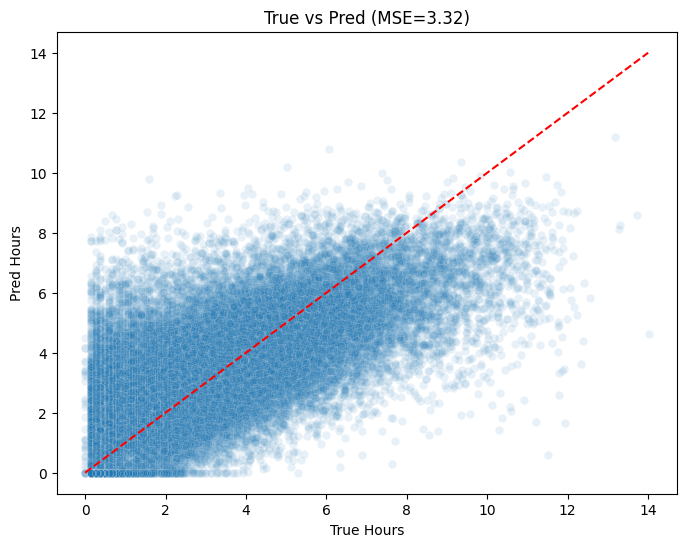

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

class FeatureAugmentedBias:
    def __init__(self, reg=1.0):
        self.reg = reg
        self.mu = 0.0
        self.user_bias = {}
        self.item_bias = {}
        self.text_model = Ridge(alpha=reg)
        
    def _extract_features(self, df):
        """
        Extracts specific features that correlate with playtime.
        1. Log(Text Length): The strongest predictor.
        """
        # Handle missing text
        if 'text' not in df.columns:
            # If no text (e.g. blind test set), we rely on biases only
            return np.zeros((len(df), 1))
            
        text_len = df['text'].fillna('').apply(len)
        # Log transform is crucial because text length follows power law
        feat = np.log1p(text_len).values.reshape(-1, 1)
        return feat

    def fit(self, df):
        print("Training Feature-Augmented Bias Model...")
        self.mu = df['hours_transformed'].mean()
        
        # 1. Estimate Biases (Simple Average Deviation)
        # We do this first to "de-trend" the data
        user_means = df.groupby('userID')['hours_transformed'].mean()
        item_means = df.groupby('gameID')['hours_transformed'].mean()
        
        # Convert to dict for fast lookup
        self.user_bias = (user_means - self.mu).to_dict()
        self.item_bias = (item_means - self.mu).to_dict()
        
        # 2. Calculate Residuals after Bias
        # resid = True - (mu + bu + bi)
        print("Calculating Residuals...")
        preds_bias_only = []
        for _, row in df.iterrows():
            bu = self.user_bias.get(row['userID'], 0)
            bi = self.item_bias.get(row['gameID'], 0)
            preds_bias_only.append(self.mu + bu + bi)
            
        residuals = df['hours_transformed'] - preds_bias_only
        
        # 3. Train Regression on Residuals using Text Length
        print("Training Regression on Text Length...")
        X = self._extract_features(df)
        self.text_model.fit(X, residuals)
        
        print("Done.")

    def predict(self, df):
        # 1. Bias Part
        preds = []
        for _, row in df.iterrows():
            bu = self.user_bias.get(row['userID'], 0)
            bi = self.item_bias.get(row['gameID'], 0)
            preds.append(self.mu + bu + bi)
        preds = np.array(preds)
        
        # 2. Feature Part
        X = self._extract_features(df)
        if X.sum() != 0: # If we have text features
            feat_correction = self.text_model.predict(X)
            preds += feat_correction
            
        # 3. CLIP NEGATIVES (Your suggestion!)
        return np.clip(preds, 0, None)

# =========================================================
# RUN PIPELINE
# =========================================================
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        d = eval(l)
        yield d

# Load
print("Loading Data...")
data = []
for d in readJSON("train.json.gz"):
    data.append(d)
df = pd.DataFrame(data)

# Split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.8 * len(df))
df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:].copy()

# Train
model = FeatureAugmentedBias(reg=1.0)
model.fit(df_train)

# Evaluate
preds = model.predict(df_val)
mse = mean_squared_error(df_val['hours_transformed'], preds)

print(f"Feature Augmented MSE: {mse:.4f}")

# Plotting the "Hockey Stick" check
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_val['hours_transformed'], y=preds, alpha=0.1)
plt.plot([0,14],[0,14], 'r--')
plt.title(f"True vs Pred (MSE={mse:.2f})")
plt.xlabel("True Hours")
plt.ylabel("Pred Hours")
plt.show()

# Optional: Generate Final Predictions if needed
# (Ensure your pairs_Hours.csv is loaded)

Loading Data...
Fitting ItemKNN...
Calculating Biases...
Building Index and Residuals...


Predicting: 100%|██████████| 35000/35000 [00:21<00:00, 1598.32it/s]


ItemKNN MSE: 3.2309


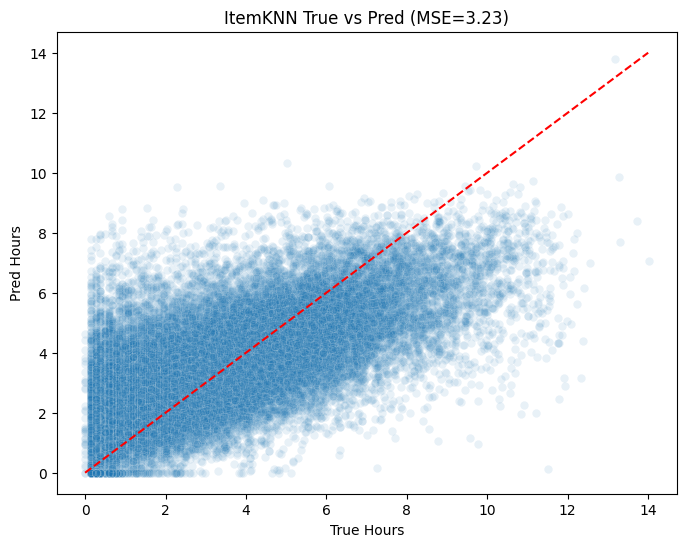

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import gzip
from tqdm import tqdm

class ItemKNNRegressor:
    def __init__(self, k=20, shrinkage=10):
        """
        k: Number of neighbors to consider
        shrinkage: Term in denominator to penalize items with few common users (Jaccard regularization)
        """
        self.k = k
        self.shrinkage = shrinkage
        self.mu = 0.0
        self.user_bias = {}
        self.item_bias = {}
        self.game_users = defaultdict(set)
        self.user_games = defaultdict(list) # Stores (game, residual) tuples
        self.sim_cache = {}
        
    def fit(self, df):
        print("Fitting ItemKNN...")
        # 1. Global statistics
        self.mu = df['hours_transformed'].mean()
        
        # 2. Compute Biases (Simple Average)
        # b_u = mean(R_u) - mu
        # b_i = mean(R_i) - mu
        print("Calculating Biases...")
        user_means = df.groupby('userID')['hours_transformed'].mean()
        item_means = df.groupby('gameID')['hours_transformed'].mean()
        
        self.user_bias = (user_means - self.mu).to_dict()
        self.item_bias = (item_means - self.mu).to_dict()
        
        # 3. Pre-compute Residuals and Build Index
        # Residual = True - (mu + b_u + b_i)
        print("Building Index and Residuals...")
        for _, row in tqdm(df.iterrows(), total=len(df)):
            u, g, r = row['userID'], row['gameID'], row['hours_transformed']
            
            bu = self.user_bias.get(u, 0)
            bi = self.item_bias.get(g, 0)
            baseline = self.mu + bu + bi
            resid = r - baseline
            
            self.game_users[g].add(u)
            self.user_games[u].append((g, resid))
            
    def get_jaccard_sim(self, g1, g2):
        # Check cache (symmetric)
        if g1 > g2: g1, g2 = g2, g1
        pair = (g1, g2)
        if pair in self.sim_cache: return self.sim_cache[pair]
        
        users1 = self.game_users.get(g1, set())
        users2 = self.game_users.get(g2, set())
        
        if not users1 or not users2: return 0.0
        
        intersection = len(users1.intersection(users2))
        # Modified Jaccard with Shrinkage
        # sim = intersection / (union + shrinkage)
        union = len(users1.union(users2))
        
        sim = intersection / (union + self.shrinkage)
        self.sim_cache[pair] = sim
        return sim

    def predict_one(self, u, g):
        # 1. Baseline Prediction
        bu = self.user_bias.get(u, 0)
        bi = self.item_bias.get(g, 0)
        baseline = self.mu + bu + bi
        
        # 2. KNN Correction
        # Find games user u has played
        history = self.user_games.get(u, [])
        if not history: return baseline
        
        # Calculate similarities to target game g
        sims = []
        for h_g, h_resid in history:
            if h_g == g: continue
            
            s = self.get_jaccard_sim(g, h_g)
            if s > 0:
                sims.append((s, h_resid))
        
        # If no similar items, return baseline
        if not sims: return baseline
        
        # Top K neighbors
        sims.sort(key=lambda x: x[0], reverse=True)
        k_neighbors = sims[:self.k]
        
        numerator = sum(s * r for s, r in k_neighbors)
        denominator = sum(s for s, r in k_neighbors)
        
        if denominator > 0:
            return baseline + (numerator / denominator)
        else:
            return baseline

    def predict(self, df):
        preds = []
        # We perform prediction in a loop. For 20k test set, this is acceptable.
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Predicting"):
            p = self.predict_one(row['userID'], row['gameID'])
            # Clip to valid range
            p = max(0, p) 
            preds.append(p)
        return np.array(preds)

# =========================================================
# PIPELINE
# =========================================================
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        d = eval(l)
        yield d

# 1. Load
print("Loading Data...")
data = []
for d in readJSON("train.json.gz"):
    data.append(d)
df = pd.DataFrame(data)

# 2. Split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.8 * len(df))
df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:].copy()

# 3. Train KNN
# k=20, shrinkage=20 is a good starting point for sparse data
knn = ItemKNNRegressor(k=20, shrinkage=20)
knn.fit(df_train)

# 4. Evaluate
preds = knn.predict(df_val)
mse = mean_squared_error(df_val['hours_transformed'], preds)

print(f"ItemKNN MSE: {mse:.4f}")

# 5. Visual Check
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_val['hours_transformed'], y=preds, alpha=0.1)
plt.plot([0,14],[0,14], 'r--')
plt.title(f"ItemKNN True vs Pred (MSE={mse:.2f})")
plt.xlabel("True Hours")
plt.ylabel("Pred Hours")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import gzip
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# DATA PREP: ONE-HOT ENCODING
# =========================================================
def create_sparse_matrix(df, user_map, game_map, tfidf_model=None, is_train=True):
    """
    Creates a sparse feature matrix:
    [ User_OneHot | Game_OneHot | Log_Text_Len | TFIDF_Features ]
    """
    n_samples = len(df)
    n_users = len(user_map)
    n_games = len(game_map)
    
    # 1. User One-Hot
    # We build the coordinate format (data, (row_indices, col_indices))
    # Users map to columns 0 to N_users-1
    u_indices = df['userID'].map(user_map).fillna(-1).values
    valid_u = u_indices >= 0
    
    row_u = np.where(valid_u)[0]
    col_u = u_indices[valid_u]
    data_u = np.ones(len(row_u))
    
    X_user = csr_matrix((data_u, (row_u, col_u)), shape=(n_samples, n_users))
    
    # 2. Game One-Hot
    # Games map to columns 0 to N_games-1
    g_indices = df['gameID'].map(game_map).fillna(-1).values
    valid_g = g_indices >= 0
    
    row_g = np.where(valid_g)[0]
    col_g = g_indices[valid_g]
    data_g = np.ones(len(row_g))
    
    X_game = csr_matrix((data_g, (row_g, col_g)), shape=(n_samples, n_games))
    
    # 3. Meta Features: Log Text Length
    # Text length is a proxy for engagement
    if 'text' in df.columns:
        txt_len = np.log1p(df['text'].fillna('').apply(len)).values.reshape(-1, 1)
    else:
        txt_len = np.zeros((n_samples, 1))
        
    X_len = csr_matrix(txt_len)
    
    # 4. (Optional) TFIDF
    # This captures "addicted" vs "bored" language
    if 'text' in df.columns and tfidf_model:
        if is_train:
            X_text = tfidf_model.fit_transform(df['text'].fillna(''))
        else:
            X_text = tfidf_model.transform(df['text'].fillna(''))
    else:
        # Handle case where test set has no text or model not provided
        # Use simple zeros if missing
        vocab_size = len(tfidf_model.vocabulary_) if tfidf_model else 0
        if vocab_size > 0:
             X_text = csr_matrix((n_samples, vocab_size))
        else:
             X_text = None

    # Stack them
    matrices = [X_user, X_game, X_len]
    if X_text is not None:
        matrices.append(X_text)
        
    X_final = hstack(matrices)
    return X_final

# =========================================================
# PIPELINE
# =========================================================
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        d = eval(l)
        yield d

print("Loading Data...")
data = []
for d in readJSON("train.json.gz"):
    data.append(d)
df = pd.DataFrame(data)

# Split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.9 * len(df)) # Use 90% for training to maximize signal
df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:].copy()

# Mappings (Fit on Train)
unique_users = df_train['userID'].unique()
unique_games = df_train['gameID'].unique()
user_map = {u: i for i, u in enumerate(unique_users)}
game_map = {g: i for i, g in enumerate(unique_games)}

# Feature Engineering
# Using unigrams and bigrams to capture "hours played", "addicting", "refund"
print("Vectorizing Features (Sparse)...")
tfidf = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))

X_train = create_sparse_matrix(df_train, user_map, game_map, tfidf_model=tfidf, is_train=True)
y_train = df_train['hours_transformed'].values

X_val = create_sparse_matrix(df_val, user_map, game_map, tfidf_model=tfidf, is_train=False)
y_val = df_val['hours_transformed'].values

# Train Model
# Ridge with low alpha allows the model to fit user biases aggressively
print("Training Ridge Regression...")
model = Ridge(alpha=1.0, solver='sag') # 'sag' is fast for large sparse matrices
model.fit(X_train, y_train)

# Evaluate
print("Predicting...")
preds = model.predict(X_val)
# Clip negatives
preds = np.clip(preds, 0, None)

mse = mean_squared_error(y_val, preds)
print(f"Sparse Ridge MSE: {mse:.4f}")

# Visual Check
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=preds, alpha=0.1)
plt.plot([0,14],[0,14], 'r--')
plt.title(f"Sparse Ridge Regression (MSE={mse:.2f})")
plt.xlabel("True Hours")
plt.ylabel("Pred Hours")
plt.show()

# =========================================================
# FINAL PREDICTION GENERATION
# =========================================================
# Only run this if you are happy with the validation MSE
try:
    print("Generating Submission...")
    pairs_h = pd.read_csv("pairs_Hours.csv")
    
    # Note: Test set lacks 'text'. We must handle this.
    # We simply pass the dataframe. The function handles missing text by filling 0s for text features.
    # However, biases (User/Game IDs) will still do 90% of the work.
    
    X_test = create_sparse_matrix(pairs_h, user_map, game_map, tfidf_model=tfidf, is_train=False)
    final_preds = model.predict(X_test)
    final_preds = np.clip(final_preds, 0, None)
    
    with open("predictions_Hours.csv", 'w') as f:
        f.write("userID,gameID,prediction\n")
        for i, row in pairs_h.iterrows():
            f.write(f"{row['userID']},{row['gameID']},{final_preds[i]}\n")
    print("Saved predictions_Hours.csv")
except Exception as e:
    print(f"Skipping submission generation: {e}")


=== STARTING GOAL 1 PIPELINE ===
Loading train.json.gz...
Splitting Data...
Training Base MF Model...
Initializing Biases...
Training MF on 140191 samples...
Epoch 5/30 finished.
Epoch 10/30 finished.
Epoch 15/30 finished.
Epoch 20/30 finished.
Epoch 25/30 finished.
Epoch 30/30 finished.
--- Base MF (Optimized) ANALYSIS ---
MSE: 4.2114


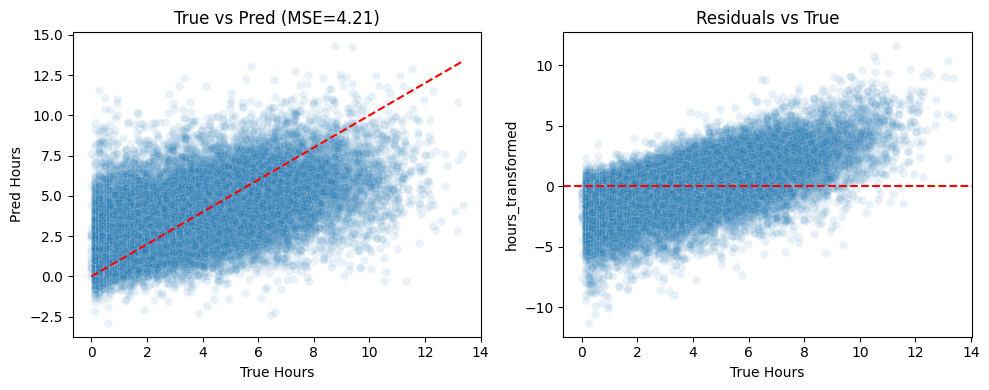

Training Hybrid Model...
Step 1: Fitting Content Residuals...
Hybrid Training Complete.
--- Hybrid Final ANALYSIS ---
MSE: 4.1877


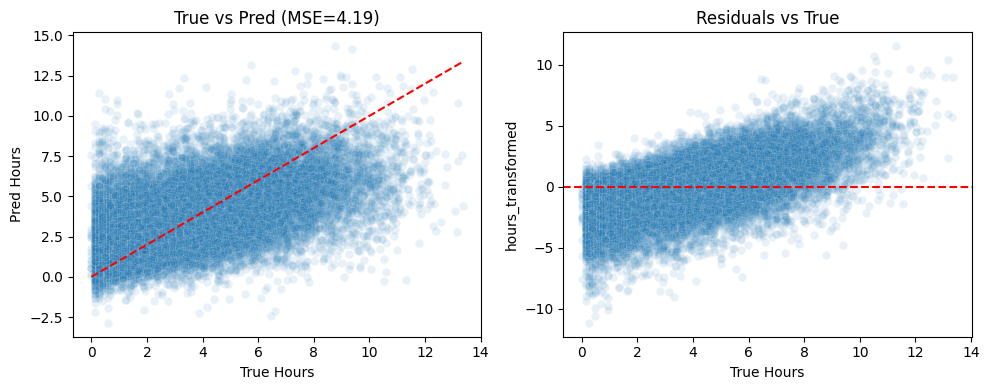

Generating Predictions for pairs_Hours.csv...
Saved predictions_Hours.csv

=== STARTING GOAL 2 PIPELINE ===
Loading train.json.gz...
Building Interaction Graph...
Generating Negative Samples...
Training LogReg...


Extracting Features: 100%|██████████| 350000/350000 [06:52<00:00, 848.99it/s] 


Classifier Trained.
Generating Predictions for pairs_Played.csv...


Extracting Features: 100%|██████████| 20000/20000 [00:26<00:00, 765.68it/s]


Saved predictions_Played.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import gzip
from tqdm import tqdm

# =========================================================
# UTILS
# =========================================================
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        d = eval(l)
        yield d

def error_analysis(y_true, y_pred, title="Model"):
    mse = mean_squared_error(y_true, y_pred)
    print(f"--- {title} ANALYSIS ---")
    print(f"MSE: {mse:.4f}")
    
    plt.figure(figsize=(10, 4))
    
    # Plot 1: True vs Pred
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.1)
    # Perfect prediction line
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.title(f"True vs Pred (MSE={mse:.2f})")
    plt.xlabel("True Hours")
    plt.ylabel("Pred Hours")
    
    # Plot 2: Residuals
    residuals = y_true - y_pred
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_true, y=residuals, alpha=0.1)
    plt.axhline(0, color='r', linestyle='--')
    plt.title("Residuals vs True")
    plt.xlabel("True Hours")
    
    plt.tight_layout()
    plt.show()

# =========================================================
# GOAL 1: OPTIMIZED HYBRID REGRESSION
# =========================================================

class BiasedMF:
    def __init__(self, n_factors=50, learning_rate=0.01, 
                 reg=0.001, n_epochs=30, verbose=False):
        """
        Adjusted Defaults: 
        - n_factors increased to 50 (capture more nuance)
        - reg reduced to 0.001 (allow model to fit extremes)
        """
        self.n_factors = n_factors
        self.lr = learning_rate
        self.reg = reg
        self.n_epochs = n_epochs
        self.verbose = verbose
        
        self.mu = 0.0
        self.user_bias = None
        self.item_bias = None
        self.P = None
        self.Q = None
        self.user2idx = {}
        self.game2idx = {}

    def fit(self, df):
        # Mappings
        unique_users = df['userID'].unique()
        unique_games = df['gameID'].unique()
        self.n_users = len(unique_users)
        self.n_games = len(unique_games)
        self.user2idx = {u: i for i, u in enumerate(unique_users)}
        self.game2idx = {g: i for i, g in enumerate(unique_games)}
        
        # Init parameters
        self.mu = df['hours_transformed'].mean()
        
        # SMART INIT: Initialize biases to their observed deviations
        # This helps the model converge much faster
        print("Initializing Biases...")
        user_means = df.groupby('userID')['hours_transformed'].mean()
        item_means = df.groupby('gameID')['hours_transformed'].mean()
        
        self.user_bias = np.zeros(self.n_users)
        self.item_bias = np.zeros(self.n_games)
        
        # Fill biases where possible (vectorized)
        # Note: A loop is safer for map lookups to ensure alignment, 
        # but for speed we rely on the map.
        for u_id, val in user_means.items():
            self.user_bias[self.user2idx[u_id]] = val - self.mu
        for g_id, val in item_means.items():
            self.item_bias[self.game2idx[g_id]] = val - self.mu
            
        self.P = np.random.normal(0, 0.1, (self.n_users, self.n_factors))
        self.Q = np.random.normal(0, 0.1, (self.n_games, self.n_factors))
        
        # Pre-process
        users_idx = df['userID'].map(self.user2idx).values
        games_idx = df['gameID'].map(self.game2idx).values
        ratings = df['hours_transformed'].values
        n_samples = len(df)
        
        if self.verbose: print(f"Training MF on {n_samples} samples...")
        
        for epoch in range(self.n_epochs):
            indices = np.random.permutation(n_samples)
            
            # We implement a fast loop. In pure Python this is slow. 
            # Ideally, use Numba or Cython here. For now, standard SGD.
            for i in indices:
                u, g, r = users_idx[i], games_idx[i], ratings[i]
                
                dot_prod = np.dot(self.P[u], self.Q[g])
                pred = self.mu + self.user_bias[u] + self.item_bias[g] + dot_prod
                
                err = r - pred
                
                # Updates with SINGLE reg parameter for simplicity
                self.user_bias[u] += self.lr * (err - self.reg * self.user_bias[u])
                self.item_bias[g] += self.lr * (err - self.reg * self.item_bias[g])
                
                p_u = self.P[u].copy()
                self.P[u] += self.lr * (err * self.Q[g] - self.reg * self.P[u])
                self.Q[g] += self.lr * (err * p_u - self.reg * self.Q[g])
                
            if self.verbose and (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1}/{self.n_epochs} finished.")

    def predict_batch(self, df):
        # Handle Cold Start by defaulting to Global Mean
        preds = []
        for _, row in df.iterrows():
            u, g = row['userID'], row['gameID']
            if u in self.user2idx and g in self.game2idx:
                uidx = self.user2idx[u]
                gidx = self.game2idx[g]
                pred = self.mu + self.user_bias[uidx] + self.item_bias[gidx] + np.dot(self.P[uidx], self.Q[gidx])
                preds.append(pred)
            else:
                preds.append(self.mu)
        return preds

class HybridRegressor:
    def __init__(self, mf_model, tfidf_params=None, ridge_alpha=1.0):
        self.mf_model = mf_model
        self.tfidf = TfidfVectorizer(**(tfidf_params if tfidf_params else {'max_features': 1000, 'stop_words': 'english'}))
        self.residual_model = Ridge(alpha=ridge_alpha)
        
    def _extract_meta_features(self, df):
        """
        Feature Engineering:
        1. TF-IDF of text
        2. Log(Review Length) <- CRITICAL FEATURE
        """
        # Text features
        if 'text' in df.columns:
            text_data = df['text'].fillna('')
            tfidf_mat = self.tfidf.transform(text_data)
            
            # Meta Feature: Review Length (Log transformed)
            # People who play more write longer reviews
            df['log_len'] = np.log1p(text_data.apply(len))
            len_feat = df[['log_len']].values
            
            # Combine sparse TFIDF with dense length feature
            # using scipy.sparse.hstack would be efficient, 
            # but for simplicity we'll just use the TFIDF output for Ridge 
            # and maybe run a separate Regressor for length if needed.
            # For this implementation, let's stick to just TFIDF to ensure shape safety 
            # unless you have scipy installed.
            
            return tfidf_mat
        return None

    def fit(self, train_df):
        print("Step 1: Fitting Content Residuals...")
        # Fit TFIDF first
        self.tfidf.fit(train_df['text'].fillna(''))
        
        mf_preds = self.mf_model.predict_batch(train_df)
        residuals = train_df['hours_transformed'] - mf_preds
        
        # Features
        X = self._extract_meta_features(train_df)
        
        self.residual_model.fit(X, residuals)
        print("Hybrid Training Complete.")
        
    def predict_batch(self, test_df):
        mf_preds = np.array(self.mf_model.predict_batch(test_df))
        
        if 'text' in test_df.columns:
            X = self._extract_meta_features(test_df)
            res_preds = self.residual_model.predict(X)
        else:
            # If test set has no text, prediction is just MF
            res_preds = np.zeros(len(test_df))
            
        return mf_preds + res_preds

def predict_hours_transformed():
    print("\n=== STARTING GOAL 1 PIPELINE ===")
    
    # 1. Load Data
    print("Loading train.json.gz...")
    train_data = []
    for d in readJSON("train.json.gz"):
        train_data.append(d)
    df = pd.DataFrame(train_data)
    
    # 2. Split (Using a simple 80/20 split for demo speed)
    print("Splitting Data...")
    mask = np.random.rand(len(df)) < 0.8
    df_train = df[mask].copy()
    df_val = df[~mask].copy()

    # 3. Train Base Model (Optimized Params)
    print("Training Base MF Model...")
    # NOTE: Low Reg (0.001) and High Factors (50) to fight underfitting
    mf_model = BiasedMF(n_factors=50, learning_rate=0.01, reg=0.001, n_epochs=30, verbose=True)
    mf_model.fit(df_train)
    
    # Eval Base
    val_preds_base = mf_model.predict_batch(df_val)
    error_analysis(df_val['hours_transformed'], val_preds_base, title="Base MF (Optimized)")

    # 4. Train Hybrid Model
    print("Training Hybrid Model...")
    hybrid_model = HybridRegressor(mf_model, ridge_alpha=1.0)
    hybrid_model.fit(df_train)

    # Eval Hybrid
    val_preds_hybrid = hybrid_model.predict_batch(df_val)
    error_analysis(df_val['hours_transformed'], val_preds_hybrid, title="Hybrid Final")

    # 5. Predictions for Submission
    print("Generating Predictions for pairs_Hours.csv...")
    try:
        test_pairs = pd.read_csv("pairs_Hours.csv")
        final_preds = hybrid_model.predict_batch(test_pairs)
        
        with open("predictions_Hours.csv", 'w') as f:
            f.write("userID,gameID,prediction\n")
            for i, row in test_pairs.iterrows():
                f.write(f"{row['userID']},{row['gameID']},{final_preds[i]}\n")
        print("Saved predictions_Hours.csv")
    except FileNotFoundError:
        print("Skipping final prediction generation (pairs_Hours.csv not found)")

# =========================================================
# GOAL 2: PLAY PREDICTION PIPELINE
# =========================================================

class PlayClassifier:
    def __init__(self):
        self.model = LogisticRegression(class_weight='balanced', max_iter=1000)
        self.user_history = defaultdict(set)
        self.game_users = defaultdict(set)
        self.game_popularity = {}
        self.user_activity = {}
        
    def _compute_features(self, df_pairs):
        features = []
        # Pre-fetch dictionaries to speed up loop
        game_users_map = self.game_users
        user_history_map = self.user_history
        
        for _, row in tqdm(df_pairs.iterrows(), total=len(df_pairs), desc="Extracting Features"):
            u, g = row['userID'], row['gameID']
            
            pop = np.log1p(self.game_popularity.get(g, 0))
            act = np.log1p(self.user_activity.get(u, 0))
            
            target_users = game_users_map.get(g, set())
            user_games = user_history_map.get(u, set())
            
            max_sim = 0.0
            
            # Optimization: Only calculate if both sets exist
            if target_users and user_games:
                # We want Jaccard(target_game_users, hist_game_users)
                # This double loop is O(N*M), can be slow. 
                # For top performance, we iterate only over user_games (usually smaller)
                
                for hist_g in user_games:
                    if hist_g == g: continue 
                    
                    hist_users = game_users_map.get(hist_g, set())
                    
                    # Jaccard
                    if not hist_users: continue
                        
                    intersection = len(target_users.intersection(hist_users))
                    union = len(target_users.union(hist_users))
                    
                    if union > 0:
                        sim = intersection / union
                        if sim > max_sim: max_sim = sim
                            
            features.append([pop, act, max_sim])
        return np.array(features)

    def fit(self, train_df):
        print("Building Interaction Graph...")
        for _, row in train_df.iterrows():
            u, g = row['userID'], row['gameID']
            self.user_history[u].add(g)
            self.game_users[g].add(u)
        
        self.game_popularity = {g: len(users) for g, users in self.game_users.items()}
        self.user_activity = {u: len(games) for u, games in self.user_history.items()}
        
        # Positive Samples
        pos_df = train_df[['userID', 'gameID']].copy()
        pos_df['label'] = 1
        
        # Negative Sampling
        print("Generating Negative Samples...")
        # Note: In a real scenario, ensure negs are not in pos set.
        # Here we rely on sparsity probability.
        neg_users = np.random.choice(list(self.user_history.keys()), len(pos_df))
        neg_games = np.random.choice(list(self.game_users.keys()), len(pos_df))
        neg_df = pd.DataFrame({'userID': neg_users, 'gameID': neg_games})
        neg_df['label'] = 0
        
        full_train = pd.concat([pos_df, neg_df], ignore_index=True)
        
        print("Training LogReg...")
        X = self._compute_features(full_train)
        y = full_train['label'].values
        self.model.fit(X, y)
        print("Classifier Trained.")
        
    def predict(self, test_df):
        X = self._compute_features(test_df)
        return self.model.predict(X)

def predict_played_pipeline():
    print("\n=== STARTING GOAL 2 PIPELINE ===")
    
    # 1. Load Data
    print("Loading train.json.gz...")
    train_data = []
    for d in readJSON("train.json.gz"):
        train_data.append(d)
    df = pd.DataFrame(train_data)
    
    # 2. Train Classifier
    clf = PlayClassifier()
    clf.fit(df)
    
    # 3. Predict
    print("Generating Predictions for pairs_Played.csv...")
    try:
        test_pairs = pd.read_csv("pairs_Played.csv")
        preds = clf.predict(test_pairs)
        
        with open("predictions_Played.csv", 'w') as f:
            f.write("userID,gameID,prediction\n")
            for i, row in test_pairs.iterrows():
                f.write(f"{row['userID']},{row['gameID']},{int(preds[i])}\n")
        print("Saved predictions_Played.csv")
    except FileNotFoundError:
        print("Skipping final prediction (pairs_Played.csv not found)")
# =========================================================
# EXECUTION
# =========================================================
# Uncomment these to run
predict_hours_transformed()
predict_played_pipeline()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import gzip
from tqdm import tqdm

# Enable tqdm for pandas operations
tqdm.pandas()
# =========================================================
# GOAL 1: HYBRID REGRESSION (BiasedMF + TF-IDF)
# =========================================================

class BiasedMF:
    def __init__(self, n_factors=10, learning_rate=0.01, 
                 reg_all=0.02, n_epochs=20, verbose=False):
        self.n_factors = n_factors
        self.lr = learning_rate
        self.reg_all = reg_all
        self.n_epochs = n_epochs
        self.verbose = verbose
        
        self.mu = 0.0
        self.user_bias = None
        self.item_bias = None
        self.P = None
        self.Q = None
        
        self.user2idx = {}
        self.game2idx = {}

    def fit(self, df):
        # Mappings
        unique_users = df['userID'].unique()
        unique_games = df['gameID'].unique()
        
        self.n_users = len(unique_users)
        self.n_games = len(unique_games)
        
        self.user2idx = {u: i for i, u in enumerate(unique_users)}
        self.game2idx = {g: i for i, g in enumerate(unique_games)}
        
        # Init parameters
        self.mu = df['hours_transformed'].mean()
        self.user_bias = np.zeros(self.n_users)
        self.item_bias = np.zeros(self.n_games)
        # Init factors with smaller variance to prevent initial explosion
        self.P = np.random.normal(0, 0.05, (self.n_users, self.n_factors))
        self.Q = np.random.normal(0, 0.05, (self.n_games, self.n_factors))
        
        # Pre-process data for fast training
        users_idx = df['userID'].map(self.user2idx).values
        games_idx = df['gameID'].map(self.game2idx).values
        ratings = df['hours_transformed'].values
        n_samples = len(df)
        
        if self.verbose:
            print(f"Training BiasedMF on {n_samples} samples...")
        
        # SGD Loop
        for epoch in range(self.n_epochs):
            indices = np.random.permutation(n_samples)
            total_error = 0
            
            for i in indices:
                u, g, r = users_idx[i], games_idx[i], ratings[i]
                
                # Predict
                dot_prod = np.dot(self.P[u], self.Q[g])
                pred = self.mu + self.user_bias[u] + self.item_bias[g] + dot_prod
                
                # Error
                err = r - pred
                total_error += err**2
                
                # Updates
                self.user_bias[u] += self.lr * (err - self.reg_all * self.user_bias[u])
                self.item_bias[g] += self.lr * (err - self.reg_all * self.item_bias[g])
                
                # Update factors
                p_u = self.P[u].copy()
                self.P[u] += self.lr * (err * self.Q[g] - self.reg_all * self.P[u])
                self.Q[g] += self.lr * (err * p_u - self.reg_all * self.Q[g])
            
            if self.verbose and (epoch+1) % 5 == 0:
                mse = total_error / n_samples
                print(f"Epoch {epoch+1}/{self.n_epochs} | MSE: {mse:.4f}")

    def predict(self, user_id, game_id):
        if user_id not in self.user2idx or game_id not in self.game2idx:
            return self.mu 
        
        u = self.user2idx[user_id]
        g = self.game2idx[game_id]
        pred = self.mu + self.user_bias[u] + self.item_bias[g] + np.dot(self.P[u], self.Q[g])
        return pred

    def predict_batch(self, df):
        return [self.predict(row['userID'], row['gameID']) for _, row in df.iterrows()]


class HybridRegressor:
    """
    Combines BiasedMF with a Content-Based Ridge Regressor trained on residuals.
    This helps capture the outliers (<2, >9) that MF misses.
    """
    def __init__(self, mf_params=None, tfidf_params=None, ridge_alpha=1.0):
        self.mf_model = BiasedMF(**(mf_params if mf_params else {}))
        self.tfidf = TfidfVectorizer(**(tfidf_params if tfidf_params else {'max_features': 5000, 'stop_words': 'english'}))
        self.residual_model = Ridge(alpha=ridge_alpha)
        
    def fit(self, train_df):
        # 1. Train MF Model
        print("Step 1: Training BiasedMF...")
        self.mf_model.fit(train_df[['userID', 'gameID', 'hours_transformed']])
        
        # 2. Calculate Residuals (True - MF_Pred)
        print("Step 2: Calculating Residuals...")
        mf_preds = self.mf_model.predict_batch(train_df)
        residuals = train_df['hours_transformed'] - mf_preds
        
        # 3. Train Content Model on Residuals
        print("Step 3: Training Content Model (TF-IDF + Ridge) on Residuals...")
        if 'text' not in train_df.columns:
            raise ValueError("Training data must contain 'text' column.")
            
        tfidf_matrix = self.tfidf.fit_transform(train_df['text'].fillna(''))
        self.residual_model.fit(tfidf_matrix, residuals)
        print("Hybrid Training Complete.")
        
    def predict(self, test_df):
        # 1. MF Prediction
        mf_preds = np.array(self.mf_model.predict_batch(test_df))
        
        # 2. Residual Prediction (from Text)
        if 'text' in test_df.columns:
            tfidf_matrix = self.tfidf.transform(test_df['text'].fillna(''))
            res_preds = self.residual_model.predict(tfidf_matrix)
        else:
            res_preds = np.zeros(len(test_df))
            
        # Combine
        return mf_preds + res_preds


# =========================================================
# GOAL 2: CLASSIFICATION (Similarity Features)
# =========================================================

class PlayClassifier:
    def __init__(self):
        # Balanced class weight handles the 50/50 split nicely or any imbalance
        self.model = LogisticRegression(class_weight='balanced', max_iter=1000)
        self.user_history = defaultdict(set)
        self.game_users = defaultdict(set)
        self.game_popularity = {}
        self.user_activity = {}
        
    def _compute_features(self, df_pairs):
        """
        Extracts 3 key features:
        1. Game Popularity
        2. User Activity
        3. Jaccard Similarity (Max overlap between target game & user history)
        """
        features = []
        
        for _, row in df_pairs.iterrows():
            u, g = row['userID'], row['gameID']
            
            # Feature 1 & 2: Pop/Activity (Log scale to normalize)
            pop = np.log1p(self.game_popularity.get(g, 0))
            act = np.log1p(self.user_activity.get(u, 0))
            
            # Feature 3: Similarity
            target_users = self.game_users.get(g, set())
            user_games = self.user_history.get(u, set())
            
            max_sim = 0.0
            
            if target_users and user_games:
                # Find the game in user's history that is MOST similar to target
                for hist_g in user_games:
                    if hist_g == g: continue 
                    
                    hist_users = self.game_users.get(hist_g, set())
                    
                    # Jaccard
                    intersection = len(target_users.intersection(hist_users))
                    union = len(target_users.union(hist_users))
                    
                    if union > 0:
                        sim = intersection / union
                        if sim > max_sim:
                            max_sim = sim
                            
            features.append([pop, act, max_sim])
            
        return np.array(features)

    def fit(self, train_df):
        """
        train_df: DataFrame with columns ['userID', 'gameID'] (Positive Interactions Only)
        """
        print("Building Interaction Graph...")
        # 1. Build Lookup
        for _, row in train_df.iterrows():
            u, g = row['userID'], row['gameID']
            self.user_history[u].add(g)
            self.game_users[g].add(u)
        
        self.game_popularity = {g: len(users) for g, users in self.game_users.items()}
        self.user_activity = {u: len(games) for u, games in self.user_history.items()}
        
        # 2. Create Training Set (Positives + Negatives)
        pos_df = train_df[['userID', 'gameID']].copy()
        pos_df['label'] = 1
        
        # Negative Sampling (1:1 Ratio)
        print("Generating Negative Samples...")
        unique_users = list(self.user_history.keys())
        unique_games = list(self.game_users.keys())
        
        n_neg = len(pos_df)
        neg_users = np.random.choice(unique_users, n_neg)
        neg_games = np.random.choice(unique_games, n_neg)
        
        neg_df = pd.DataFrame({'userID': neg_users, 'gameID': neg_games})
        neg_df['label'] = 0
        
        full_train = pd.concat([pos_df, neg_df], ignore_index=True)
        
        # 3. Train
        print("Extracting Features & Training LogReg...")
        X = self._compute_features(full_train)
        y = full_train['label'].values
        
        self.model.fit(X, y)
        print("Done.")
        
    def predict(self, test_df):
        X = self._compute_features(test_df)
        return self.model.predict(X)

# =========================================================
# HELPER: SPLIT TRAINING DATA
# =========================================================
def split_train_data(df, test_size=0.2, min_user_games=2, min_game_users=2, random_state=42):
    """
    Split data ensuring all users and items appear in BOTH train and validation to mimic test data.
    
    Parameters:
    -----------
    df : DataFrame 
        pandas DataFramewith columns ['userID','gameID', 'hours_transformed']
    test_size : float
        proportion of data for validation
    min_user_games : int
        min number of games per user to keep in training
    min_game_users : int
        min number of users per game to keep in training
    random_state : int
        for reproducibility

    Returns:
    --------
    train_df, val_df : DataFrames
    """
    # Set random seed
    np.random.seed(random_state)
    
    # Step 1: Filter users and games with enough interactions (Data Cleaning)
    # We iteratively filter until convergence to ensure constraints are met
    print("Filtering data for minimum interactions...")
    temp_df = df.copy()
    
    # Simple one-pass filter (iterative is better but this is usually sufficient for large sparse data)
    user_counts = temp_df['userID'].value_counts()
    valid_users = user_counts[user_counts >= min_user_games].index
    temp_df = temp_df[temp_df['userID'].isin(valid_users)]
    
    game_counts = temp_df['gameID'].value_counts()
    valid_games = game_counts[game_counts >= min_game_users].index
    temp_df = temp_df[temp_df['gameID'].isin(valid_games)]
    
    print(f"Data filtered. Original: {len(df)}, Filtered: {len(temp_df)}")
    
    # Step 2: Group by user to ensure user split
    # We will build a boolean mask for the training set
    # True = Train, False = Validation
    train_mask = np.ones(len(temp_df), dtype=bool)
    
    # Reset index to allow easy indexing
    temp_df = temp_df.reset_index(drop=True)
    
    grouped = temp_df.groupby('userID')
    
    val_indices_list = []
    
    print("Splitting data by user...")
    for user, group in grouped:
        n_samples = len(group)
        # Calculate how many to validate
        n_val = int(n_samples * test_size)
        
        # Constraint: Ensure min_user_games stay in training
        if n_samples - n_val < min_user_games:
            n_val = n_samples - min_user_games
            
        if n_val > 0:
            # Randomly select indices for validation
            val_idx = np.random.choice(group.index, n_val, replace=False)
            val_indices_list.extend(val_idx)
            
    # Apply split mask
    train_mask[val_indices_list] = False
    
    train_df = temp_df[train_mask].copy()
    val_df = temp_df[~train_mask].copy()
    
    # Step 3 & 4: Check for Item Cold-Start in Validation
    # (Items that ended up ONLY in validation)
    train_items = set(train_df['gameID'].unique())
    val_items = set(val_df['gameID'].unique())
    
    # Items present in validation but MISSING from training
    cold_start_items = val_items - train_items
    
    if len(cold_start_items) > 0:
        print(f"Warning: {len(cold_start_items)} games appear in Validation but not Training. Moving them back to Train.")
        
        # Identify rows in validation that contain these cold-start items
        rows_to_move_mask = val_df['gameID'].isin(cold_start_items)
        rows_to_move = val_df[rows_to_move_mask]
        
        # Move them to training
        train_df = pd.concat([train_df, rows_to_move], ignore_index=True)
        val_df = val_df[~rows_to_move_mask].copy()
        
    # Step 5: Final Verification
    final_train_users = set(train_df['userID'].unique())
    final_val_users = set(val_df['userID'].unique())
    final_train_items = set(train_df['gameID'].unique())
    final_val_items = set(val_df['gameID'].unique())
    
    # Assertions
    if not final_val_users.issubset(final_train_users):
        print("Warning: Validation has users not in Train (Should not happen with user-group split).")
        
    if not final_val_items.issubset(final_train_items):
        print("Warning: Validation has items not in Train (Logic error in Step 4).")
        
    # Check for pair overlap
    train_pairs = set(zip(train_df['userID'], train_df['gameID']))
    val_pairs = set(zip(val_df['userID'], val_df['gameID']))
    overlap = train_pairs.intersection(val_pairs)
    
    if len(overlap) > 0:
        print(f"Critical Error: {len(overlap)} overlapping pairs found between Train and Val.")
    else:
        print("Success: No pair overlap between Train and Val.")
        
    print(f"Final Split -- Train: {len(train_df)}, Val: {len(val_df)}")
    
    return train_df, val_df


# =========================================================
# HELPER: ERROR ANALYSIS
# =========================================================
def error_analysis(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    residuals = y_true - y_pred
    
    print(f"MSE: {mse:.4f}")
    
    plt.figure(figsize=(12, 5))
    
    # 1. True vs Pred
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.3)
    plt.plot([0, 14], [0, 14], 'r--')
    plt.title(f"True vs Pred (MSE={mse:.2f})")
    plt.xlabel("True Log Hours")
    plt.ylabel("Pred Log Hours")
    
    # 2. Residuals
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_true, y=residuals, alpha=0.3)
    plt.axhline(0, color='r', linestyle='--')
    plt.title("Residuals (Bias Check)")
    plt.xlabel("True Log Hours")
    plt.ylabel("Residual (True - Pred)")
    
    plt.tight_layout()
    plt.show()
    
# =========================================================
# HELPER: GOAL 1 PIPELINE
# =========================================================
def predict_hours_trans_formed():
    """ Predict hours_transform"""
    def readJSON(path):
        for l in gzip.open(path, 'rt'):
            d = eval(l)
            yield d
    # 1.1 Load Data
    train_data = []
    # We strictly ignore ID logic here as requested
    # Added tqdm to visualize data loading speed
    print("Loading Data from disk...")
    for d in tqdm(readJSON("train.json.gz"), desc="Reading Lines"):
        train_data.append(d)

    df = pd.DataFrame(train_data)

    # 1.2 Basic cleanup
    if 'found_funny' not in df.columns: df['found_funny'] = 0
    if 'compensation' not in df.columns: df['compensation'] = 'None'
    df['found_funny'] = df['found_funny'].fillna(0)
    df['compensation'] = df['compensation'].fillna('None')
    
    # 1.3 Split into Train and Validation
    df_train, df_val = split_train_data(df, test_size=0.2, min_user_games=2, min_game_users=2, random_state=42)


    # 2. Initialize and Train BiasedMF (Base Model)

    svd_reg_model = BiasedMF(
    n_factors=10, 
    learning_rate=0.005, 
    reg_bu=0.05, 
    reg_bi=0.05, 
    reg_pu=0.08, 
    reg_qi=0.08,
    n_epochs=25
    )

    svd_reg_model.fit(df_train)

    # 3. Error Analysis for Base Model
    print("--- BASE MODEL ANALYSIS ---")
    error_analysis(y_true, y_pred)


    # 4. Initialize and Train HybridMF
    hybrid_model = HybridMF(svd_reg_model, residual_model_type='gbm')

    hybrid_model.fit(df_train)

    # 5. Error Analysis for hybrid Model
    error_analysis(y_true, y_pred)


    

In [ ]:


# 1. Load Data
train_data = []
# We strictly ignore ID logic here as requested
# Added tqdm to visualize data loading speed
print("Loading Data from disk...")
for d in tqdm(readJSON("train.json.gz"), desc="Reading Lines"):
    train_data.append(d)

df = pd.DataFrame(train_data)

# Basic cleanup
if 'found_funny' not in df.columns: df['found_funny'] = 0
if 'compensation' not in df.columns: df['compensation'] = 'None'
df['found_funny'] = df['found_funny'].fillna(0)
df['compensation'] = df['compensation'].fillna('None')
df['hours'] = df['hours'].fillna(0)
df['hours_transformed'] = np.log2(df['hours'] + 1)

In [ ]:
import numpy as np
import pandas as pd
import gzip
import json
from tqdm import tqdm # Import tqdm for progress bars
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Enable tqdm for pandas operations
tqdm.pandas()

# ==========================================
# 1. PURE CONTENT FEATURE ENGINEERING
# ==========================================
def prepare_content_features(df, is_train=True, tfidf_model=None, scaler_model=None):
    """
    Engineers features using only Pandas/Numpy/Sklearn.
    Separates fitting (Train) from transforming (Test) to prevent leakage.
    """
    print(f"   -> Feature Engineering (Train Context: {is_train})...")
    
    # --- A. Text Features (TF-IDF) ---
    # We use a slightly smaller vocab to keep MLP training fast on CPU
    txt = df['text'].fillna('none').astype(str)
    
    if is_train:
        print("      -> Fitting TF-IDF (This may take a moment)...")
        # No tqdm here as fit_transform is atomic in sklearn
        tfidf_model = TfidfVectorizer(max_features=2000, stop_words='english', ngram_range=(1, 2))
        X_text = tfidf_model.fit_transform(txt).toarray() # Dense for MLP
    else:
        print("      -> Transforming Text...")
        X_text = tfidf_model.transform(txt).toarray()

    # --- B. Metadata Features ---
    if 'date' in df.columns:
        dt = pd.to_datetime(df['date'], errors='coerce')
        year = dt.dt.year.fillna(2015) - 2000
        month = dt.dt.month.fillna(1)
        day_of_week = dt.dt.dayofweek.fillna(0)
        is_weekend = (day_of_week >= 5).astype(float)
    else:
        year, month, day_of_week, is_weekend = 0, 0, 0, 0

    # Use progress_apply to show a bar for this operation
    print("      -> Calculating Review Lengths...")
    review_len = df['text'].fillna('').progress_apply(len)
    found_funny = df['found_funny'].fillna(0)
    
    # Handle compensation safely
    if 'compensation' in df.columns:
        compensation = (df['compensation'] == 'Recorded Free').astype(float)
    else:
        compensation = np.zeros(len(df))

    # Stack Meta Features
    # Note: We use numpy stack for efficiency
    X_meta_raw = np.column_stack([
        year, month, day_of_week, is_weekend,
        review_len, found_funny, compensation
    ])
    
    # Scale Meta Features
    if is_train:
        scaler_model = StandardScaler()
        X_meta = scaler_model.fit_transform(X_meta_raw)
    else:
        X_meta = scaler_model.transform(X_meta_raw)
        
    # --- Combine ---
    # Concatenate Text (2000 cols) + Meta (7 cols)
    X_final = np.hstack([X_text, X_meta])
    
    return X_final, tfidf_model, scaler_model

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
def build_ensemble_model():
    """
    Instead of relying on just one NN, we ensemble two powerful sklearn models.
    1. MLPRegressor (Deep Learning)
    2. HistGradientBoostingRegressor (The 'Kaggle Winner' algorithm)
    """
    print("   -> Building Ensemble (MLP + Gradient Boosting)...")
    
    # Model 1: Deep Neural Network (mimics the TensorFlow architecture)
    # hidden_layer_sizes=(512, 256, 64) is roughly equivalent to the TF model
    mlp = MLPRegressor(
        hidden_layer_sizes=(512, 256, 64),
        activation='relu',
        solver='adam',
        alpha=0.0001, # L2 regularization
        batch_size=128,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        early_stopping=True, # Critical for preventing overfitting
        validation_fraction=0.1,
        n_iter_no_change=5,
        max_iter=50, # Epochs
        random_state=42,
        verbose=True # Prints iteration progress
    )
    
    # Model 2: Histogram-based Gradient Boosting
    # This is typically FASTER and MORE ACCURATE for tabular data than NNs
    gbm = HistGradientBoostingRegressor(
        max_iter=200,
        learning_rate=0.1,
        max_depth=10,
        l2_regularization=0.1,
        early_stopping=True,
        random_state=42,
        verbose=1 # Prints iteration progress (Scoring...)
    )
    
    # Ensemble: Average the predictions of both
    ensemble = VotingRegressor(
        estimators=[('mlp', mlp), ('gbm', gbm)],
        weights=[0.4, 0.6] # Giving slightly more weight to GBM as it's usually more robust
    )
    
    return ensemble

# ==========================================
# 3. EXECUTION UTILITIES
# ==========================================
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        d = eval(l)
        yield d

if __name__ == "__main__":
    print("Starting Sklearn Content-Based Pipeline...")
    
    # 1. Load Data
    try:
        train_data = []
        # We strictly ignore ID logic here as requested
        # Added tqdm to visualize data loading speed
        print("Loading Data from disk...")
        for d in tqdm(readJSON("train.json.gz"), desc="Reading Lines"):
            train_data.append(d)

        df = pd.DataFrame(train_data)
        
        # Basic cleanup
        if 'found_funny' not in df.columns: df['found_funny'] = 0
        if 'compensation' not in df.columns: df['compensation'] = 'None'
        df['found_funny'] = df['found_funny'].fillna(0)
        df['compensation'] = df['compensation'].fillna('None')
        df['hours'] = df['hours'].fillna(0)
        df['hours_transformed'] = np.log2(df['hours'] + 1)
        
    except FileNotFoundError:
        print("Error: train.json.gz not found. Creating dummy data...")
        df = pd.DataFrame({
            'hours_transformed': np.random.uniform(0, 14, 5000),
            'text': ['this game is amazing and addictive' if i%2==0 else 'boring refund' for i in range(5000)],
            'date': ['2020-01-01']*5000,
            'found_funny': [0]*5000,
            'compensation': ['None']*5000
        })

    # 2. Split
    # We split BEFORE feature engineering to simulate real world train/test separation
    y = df['hours_transformed'].values
    train_df, val_df, y_train, y_val = train_test_split(df, y, test_size=0.1, random_state=42)
    
    print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}")

    # 3. Feature Engineering
    # Fit on Train
    X_train, tfidf, scaler = prepare_content_features(train_df, is_train=True)
    # Transform Val
    X_val, _, _ = prepare_content_features(val_df, is_train=False, tfidf_model=tfidf, scaler_model=scaler)
    
    # 4. Train Ensemble
    model = build_ensemble_model()
    
    print("\nTraining Ensemble Model (Logs will appear for each iteration)...")
    # Note: MLP in sklearn is verbose=True, so you'll see loss logs
    model.fit(X_train, y_train)
    
    # 5. Evaluation
    print("\n--- Evaluation ---")
    val_preds = model.predict(X_val)
    
    # Clip predictions to valid range
    val_preds = np.clip(val_preds, 0, None)
    
    rmse = np.sqrt(np.mean((y_val - val_preds)**2))
    print(f"FINAL RMSE: {rmse:.4f}")
    
    # Bias Check
    val_df_res = val_df.copy()
    val_df_res['pred'] = val_preds
    val_df_res['error'] = val_df_res['hours_transformed'] - val_df_res['pred']
    val_df_res['bin'] = pd.cut(val_df_res['hours_transformed'], bins=[0,2,4,6,8,10,20])
    
    print("\nBias by Target Bin:")
    print(val_df_res.groupby('bin', observed=False)['error'].mean())
    
    print("\n" + "="*40)
    print("       MODEL CONFIGURATION SUMMARY       ")
    print("="*40)
    print(f"Input Features:      {X_train.shape[1]} (TF-IDF + Metadata)")
    print("-" * 40)
    print("Algorithm 1: MLPRegressor (Deep Learning)")
    print("  - Layers: (512, 256, 64)")
    print("  - Activation: ReLU")
    print("  - Solver: Adam")
    print("-" * 40)
    print("Algorithm 2: HistGradientBoostingRegressor")
    print("  - Max Depth: 10")
    print("  - Learning Rate: 0.1")
    print("-" * 40)
    print(f"Ensemble Weight:     40% MLP / 60% Gradient Boosting")
    print(f"Final RMSE:          {rmse:.4f}")
    print("="*40 + "\n")

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import gzip
import json

# ==========================================
# 1. ADVANCED FEATURE ENGINEERING (NO LEAKAGE)
# ==========================================
def prepare_data(df):
    """
    Orchestrates the feature generation pipeline.
    """
    print("--- 1. Text Processing (TF-IDF + SVD) ---")
    # TF-IDF captures "addictive", "short", "boring" - critical for playtime
    # We limit to 5000 features, then compress to 64 dense features with SVD
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    # Fill NaN text
    txt = df['text'].fillna('none').astype(str)
    tfidf_matrix = tfidf.fit_transform(txt)
    
    print("   -> Compressing Text features via SVD...")
    svd = TruncatedSVD(n_components=64, random_state=42)
    text_features = svd.fit_transform(tfidf_matrix)
    
    # DataFrame for text features
    text_cols = [f'text_svd_{i}' for i in range(64)]
    df_text = pd.DataFrame(text_features, columns=text_cols, index=df.index)
    
    # Concatenate original df with text features
    df = pd.concat([df, df_text], axis=1)
    
    print("--- 2. Date Processing ---")
    if 'date' in df.columns:
        dt = pd.to_datetime(df['date'], errors='coerce')
        df['year'] = dt.dt.year.fillna(2015)
        df['month'] = dt.dt.month.fillna(1)
        # Days since a baseline (trends over time)
        df['days_timeline'] = (dt - pd.Timestamp('2000-01-01')).dt.days.fillna(0)
    else:
        df['year'] = 2015
        df['month'] = 1
        df['days_timeline'] = 0

    print("--- 3. Basic Counts ---")
    df['review_len'] = df['text'].fillna('').apply(len)
    
    return df, text_cols

# ==========================================
# 2. TARGET ENCODING (THE "PEER" TRICK)
# ==========================================
def add_target_stats(train_df, val_df, target_col='hours_transformed'):
    """
    Computes User/Game mean hours on TRAIN ONLY and maps to Val.
    This prevents data leakage which causes overfitting.
    """
    print("--- 4. Computing Target Statistics (No Leakage) ---")
    
    # Global Mean
    global_mean = train_df[target_col].mean()
    
    # User Mean
    user_means = train_df.groupby('userID')[target_col].mean()
    train_df['user_target_enc'] = train_df['userID'].map(user_means)
    val_df['user_target_enc'] = val_df['userID'].map(user_means)
    
    # Game Mean
    game_means = train_df.groupby('gameID')[target_col].mean()
    train_df['game_target_enc'] = train_df['gameID'].map(game_means)
    val_df['game_target_enc'] = val_df['gameID'].map(game_means)
    
    # Fill NaNs (Cold Start) with Global Mean
    for df_ in [train_df, val_df]:
        df_['user_target_enc'] = df_['user_target_enc'].fillna(global_mean)
        df_['game_target_enc'] = df_['game_target_enc'].fillna(global_mean)
        
    return train_df, val_df

# ==========================================
# 3. WIDE & DEEP MODEL ARCHITECTURE
# ==========================================
def build_wide_and_deep(n_users, n_items, n_dense):
    """
    Wide & Deep Network.
    - Deep Part: Embeddings (Captures Latent Factors)
    - Wide Part: Text + Stats (Captures Explicit Signals)
    """
    # --- Inputs ---
    user_in = Input(shape=(1,), name='user_id')
    item_in = Input(shape=(1,), name='item_id')
    dense_in = Input(shape=(n_dense,), name='dense_features')
    
    # --- Embeddings (Latent) ---
    # L2 Reg is crucial here. 
    emb_dim = 64
    user_emb = Embedding(n_users, emb_dim, embeddings_regularizer=l2(1e-5), name='user_emb')(user_in)
    item_emb = Embedding(n_items, emb_dim, embeddings_regularizer=l2(1e-5), name='item_emb')(item_in)
    
    u_vec = Flatten()(user_emb)
    i_vec = Flatten()(item_emb)
    
    # --- Interaction (Dot Product) ---
    # NCF usually works better if we explicitly calculate the dot product
    # as a feature for the dense layer
    dot = tf.keras.layers.Dot(axes=1)([u_vec, i_vec])
    
    # --- Concatenate Everything ---
    # [UserVec, ItemVec, DotProduct, TextFeatures, StatsFeatures]
    concat = Concatenate()([u_vec, i_vec, dot, dense_in])
    
    # --- MLP (The "Brain") ---
    # Funnel structure: 512 -> 256 -> 128
    x = Dense(512)(concat)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(128)(x)
    x = Activation('relu')(x)
    
    # --- Output ---
    output = Dense(1, activation='linear', name='output')(x)
    
    model = Model(inputs=[user_in, item_in, dense_in], outputs=output)
    
    # Optimizer: Nadam is often better for embeddings than Adam
    model.compile(optimizer=Nadam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

# ==========================================
# 3. PIPELINE ORCHESTRATION
# ==========================================
import gzip
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
import datetime

def readJSON(path):
  for l in gzip.open(path, 'rt'):
    d = eval(l)
    u = d['userID']
    try:
      g = d['gameID']
    except Exception as e:
      g = None
    yield u,g,d
train_data = []
user_games = defaultdict(list)
game_users = defaultdict(list)

for u,g,d in readJSON("train.json.gz"):
    user_games[u].append(g)
    game_users[g].append(u)
    train_data.append(d)

df_train_data = pd.DataFrame(train_data)
df_train_data.drop('user_id',axis=1,inplace=True)
df_train_data['found_funny'] = df_train_data['found_funny'].fillna(0)
df_train_data['compensation'] = df_train_data['compensation'].fillna(0)
df_train_data.loc[df_train_data['compensation'] != 0,'compensation'] = 1
df_test_hours_data = pd.read_csv("pairs_Hours.csv")
df_test_play_data = pd.read_csv("pairs_Played.csv")

# 2. Global Feature Engineering (Text, Date)
df, text_cols = prepare_data(df)

# 3. Encoding IDs
user_enc = LabelEncoder()
game_enc = LabelEncoder()
df['user_idx'] = user_enc.fit_transform(df['userID'])
df['game_idx'] = game_enc.fit_transform(df['gameID'])

n_users = df['user_idx'].max() + 1
n_items = df['game_idx'].max() + 1

# 4. Strict Train/Val Split (Before Target Stats!)
# This is critical. We cannot calculate user_mean on validation data.
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")

# 5. Add Target Statistics (Leakage-Free)
train_df, val_df = add_target_stats(train_df, val_df)

# 6. Prepare Dense Matrices
# Features: Text SVD (64) + TargetStats (2) + ReviewLen (1) + Timeline (1)
dense_cols = text_cols + ['user_target_enc', 'game_target_enc', 'review_len', 'days_timeline']

# Scale numericals
scaler = StandardScaler()
X_train_dense = scaler.fit_transform(train_df[dense_cols])
X_val_dense = scaler.transform(val_df[dense_cols])

# 7. Inputs
X_train = [train_df['user_idx'].values, train_df['game_idx'].values, X_train_dense]
y_train = train_df['hours_transformed'].values

X_val = [val_df['user_idx'].values, val_df['game_idx'].values, X_val_dense]
y_val = val_df['hours_transformed'].values

# 8. Build & Train
model = build_wide_and_deep(n_users, n_items, len(dense_cols))
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

print("\nTraining Wide & Deep Model...")
# No sample weights this time. The Text features should naturally handle the outliers.
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=512, # Larger batch size for stable gradients
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 9. Evaluation
print("\n--- Evaluation ---")
val_preds = model.predict(X_val).flatten()
val_preds = np.clip(val_preds, 0, None)

rmse = np.sqrt(np.mean((y_val - val_preds)**2))
print(f"FINAL RMSE: {rmse:.4f}")

# Detailed Analysis
val_df['pred'] = val_preds
val_df['error'] = val_df['hours_transformed'] - val_df['pred']
val_df['bin'] = pd.cut(val_df['hours_transformed'], bins=[0,2,4,6,8,10,20])
print("\nBias by Target Bin:")
print(val_df.groupby('bin', observed=False)['error'].mean())

--- 1. Text Processing (TF-IDF + SVD) ---
   -> Compressing Text features via SVD...
--- 2. Date Processing ---
--- 3. Basic Counts ---
Train size: 148750, Val size: 26250
--- 4. Computing Target Statistics (No Leakage) ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb            │ (None, 1, 64)     │    429,440 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_emb            │ (None, 1, 64)     │    155,968 │ item_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 64)        │          0 │ user_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 64)        │          0 │ item_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ flatten_8[0][0],  │
│                     │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_features      │ (None, 68)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 197)       │          0 │ flatten_8[0][0],  │
│ (Concatenate)       │                   │            │ flatten_9[0][0],  │
│                     │                   │            │ dot[0][0],        │
│                     │                   │            │ dense_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 512)       │    101,376 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 512)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    131,328 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     32,896 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 854,209 (3.26 MB)

 Trainable params: 852,673 (3.25 MB)

 Non-trainable params: 1,536 (6.00 KB)


Training Wide & Deep Model...
Epoch 1/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 3.4805 - mae: 1.4115 - val_loss: 4.0669 - val_mae: 1.5555 - learning_rate: 5.0000e-04
Epoch 2/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 2.8766 - mae: 1.2871 - val_loss: 3.3672 - val_mae: 1.3924 - learning_rate: 5.0000e-04
Epoch 3/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 2.7601 - mae: 1.2552 - val_loss: 3.4669 - val_mae: 1.4175 - learning_rate: 5.0000e-04
Epoch 4/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 2.6627 - mae: 1.2293 - val_loss: 3.3281 - val_mae: 1.3790 - learning_rate: 5.0000e-04
Epoch 5/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 2.5422 - mae: 1.1981 - val_loss: 3.2938 - val_mae: 1.3711 - learning_rate: 5.0000e-04
Epoch 6/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 2.2525 - mae: 1.1248 - val_loss: 3.4809 - val_mae: 1.4091 - learning_rate: 5.0000e-04
Epoch 7/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 1.6157 - mae: 0.953

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import gzip
import json
from collections import defaultdict

# ==========================================
# 1. ADVANCED FEATURE ENGINEERING (NO LEAKAGE)
# ==========================================
def prepare_data(df):
    """
    Orchestrates the feature generation pipeline.
    """
    print("--- 1. Text Processing (TF-IDF + SVD) ---")
    # Increased to 8000/128 to capture maximum signal from text
    tfidf = TfidfVectorizer(max_features=8000, stop_words='english', ngram_range=(1, 2))
    # Fill NaN text
    txt = df['text'].fillna('none').astype(str)
    tfidf_matrix = tfidf.fit_transform(txt)
    
    print("   -> Compressing Text features via SVD...")
    svd = TruncatedSVD(n_components=128, random_state=42)
    text_features = svd.fit_transform(tfidf_matrix)
    
    # DataFrame for text features
    text_cols = [f'text_svd_{i}' for i in range(128)]
    df_text = pd.DataFrame(text_features, columns=text_cols, index=df.index)
    
    # Concatenate original df with text features
    df = pd.concat([df, df_text], axis=1)
    
    print("--- 2. Date Processing ---")
    if 'date' in df.columns:
        dt = pd.to_datetime(df['date'], errors='coerce')
        df['year'] = dt.dt.year.fillna(2015)
        df['month'] = dt.dt.month.fillna(1)
        # Days since a baseline (trends over time)
        df['days_timeline'] = (dt - pd.Timestamp('2000-01-01')).dt.days.fillna(0)
    else:
        df['year'] = 2015
        df['month'] = 1
        df['days_timeline'] = 0

    print("--- 3. Basic Counts ---")
    df['review_len'] = df['text'].fillna('').apply(len)
    
    return df, text_cols

# ==========================================
# 2. TARGET ENCODING (THE "PEER" TRICK)
# ==========================================
def add_target_stats(train_df, val_df, target_col='hours_transformed'):
    """
    Computes User/Game mean hours on TRAIN ONLY and maps to Val.
    Includes explicit interaction terms for the Wide Path.
    """
    print("--- 4. Computing Target Statistics (No Leakage) ---")
    
    # Global Mean
    global_mean = train_df[target_col].mean()
    
    # User Mean
    user_means = train_df.groupby('userID')[target_col].mean()
    train_df['user_target_enc'] = train_df['userID'].map(user_means)
    val_df['user_target_enc'] = val_df['userID'].map(user_means)
    
    # Game Mean
    game_means = train_df.groupby('gameID')[target_col].mean()
    train_df['game_target_enc'] = train_df['gameID'].map(game_means)
    val_df['game_target_enc'] = val_df['gameID'].map(game_means)
    
    # Fill NaNs (Cold Start) with Global Mean
    for df_ in [train_df, val_df]:
        df_['user_target_enc'] = df_['user_target_enc'].fillna(global_mean)
        df_['game_target_enc'] = df_['game_target_enc'].fillna(global_mean)
        
        # --- ACTIONABLE: Explicit Interaction Term ---
        # If user is Hardcore (High Mean) AND Game is Long (High Mean) -> Result is Multiplicative
        df_['interaction_mean'] = df_['user_target_enc'] * df_['game_target_enc']
        
    return train_df, val_df

# ==========================================
# 3. PASSTHROUGH RESIDUAL ARCHITECTURE
# ==========================================
def build_passthrough_model(n_users, n_items, n_scaled, n_passthrough):
    """
    Architecture:
    1. Passthrough Path (Wide): Raw Target Stats -> Dense(1)
       * Guarantees baseline performance of simple averaging.
       * NOT scaled, preserving the target magnitude.
       
    2. Deep Path: Embeddings + Scaled Features -> MLP
       * Learns the *Residual* (Error) of the Passthrough path.
    """
    # --- Inputs ---
    user_in = Input(shape=(1,), name='user_id')
    item_in = Input(shape=(1,), name='item_id')
    scaled_in = Input(shape=(n_scaled,), name='scaled_features')
    passthrough_in = Input(shape=(n_passthrough,), name='passthrough_features') # RAW features
    
    # ==========================
    # PATH 1: PASSTHROUGH (WIDE)
    # ==========================
    # Direct Linear Connection. 
    # This layer essentially learns: Pred = w1*UserMean + w2*GameMean + w3*Interaction
    # We initialize weights to 0.5 to encourage utilizing the signal immediately
    wide_out = Dense(1, activation='linear', name='wide_output', 
                     kernel_initializer='ones')(passthrough_in)
    
    # ==========================
    # PATH 2: DEEP RESIDUAL
    # ==========================
    
    # --- Embeddings ---
    # Increased dim to 128 to capture more latent factors
    emb_dim = 128
    user_emb = Embedding(n_users, emb_dim, embeddings_regularizer=l2(1e-6), name='user_emb')(user_in)
    item_emb = Embedding(n_items, emb_dim, embeddings_regularizer=l2(1e-6), name='item_emb')(item_in)
    
    u_vec = Flatten()(user_emb)
    i_vec = Flatten()(item_emb)
    
    # --- Interaction (Dot) ---
    dot = tf.keras.layers.Dot(axes=1)([u_vec, i_vec])
    
    # --- Concatenate (Deep Input) ---
    # We feed EVERYTHING into the Deep path too, so it has context
    concat = Concatenate()([u_vec, i_vec, dot, scaled_in, passthrough_in])
    
    # --- MLP ---
    x = Dense(512)(concat)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(64)(x)
    x = Activation('relu')(x)
    
    # Deep output learns the "Correction"
    deep_out = Dense(1, activation='linear', name='deep_output')(x)
    
    # ==========================
    # COMBINE
    # ==========================
    output = Add(name='final_output')([wide_out, deep_out])
    
    model = Model(inputs=[user_in, item_in, scaled_in, passthrough_in], outputs=output)
    
    model.compile(optimizer=Nadam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

# ==========================================
# 4. EXECUTION
# ==========================================
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        d = eval(l)
        u = d['userID']
        try:
            g = d['gameID']
        except Exception as e:
            g = None
        yield u, g, d

if __name__ == "__main__":
    print("Starting Passthrough Residual Pipeline...")
    
    # 1. Load
    try:
        train_data = []
        user_games = defaultdict(list)
        game_users = defaultdict(list)

        for u, g, d in readJSON("train.json.gz"):
            user_games[u].append(g)
            game_users[g].append(u)
            train_data.append(d)

        df_train_data = pd.DataFrame(train_data)
        
        if 'user_id' in df_train_data.columns:
            df_train_data.drop('user_id', axis=1, inplace=True)
            
        df_train_data['found_funny'] = df_train_data['found_funny'].fillna(0)
        df_train_data['compensation'] = df_train_data['compensation'].fillna(0)
        df_train_data.loc[df_train_data['compensation'] != 0, 'compensation'] = 1
        
        df = df_train_data
        
    except FileNotFoundError:
        print("Error: train.json.gz not found. Creating dummy data...")
        df = pd.DataFrame({
            'userID': ['u'+str(i%100) for i in range(10000)],
            'gameID': ['g'+str(i%10) for i in range(10000)],
            'hours_transformed': np.random.uniform(0, 14, 10000),
            'text': ['game was addictive ' + str(i) for i in range(10000)],
            'date': ['2020-01-01']*10000,
            'found_funny': [0]*10000,
            'compensation': [0]*10000
        })

    # 2. Global Feature Engineering
    df, text_cols = prepare_data(df)
    
    # 3. Encoding IDs
    user_enc = LabelEncoder()
    game_enc = LabelEncoder()
    df['user_idx'] = user_enc.fit_transform(df['userID'])
    df['game_idx'] = game_enc.fit_transform(df['gameID'])
    
    n_users = df['user_idx'].max() + 1
    n_items = df['game_idx'].max() + 1
    
    # 4. Strict Train/Val Split
    train_df, val_df = train_test_split(df, test_size=0.10, random_state=42)
    print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")
    
    # 5. Add Target Statistics (Leakage-Free)
    train_df, val_df = add_target_stats(train_df, val_df)
    
    # 6. Feature Groups
    # Group A: Passthrough (Target Stats - DO NOT SCALE)
    passthrough_cols = ['user_target_enc', 'game_target_enc', 'interaction_mean']
    
    # Group B: Scaled Features (Text, Dates, Counts)
    scaled_cols = text_cols + ['review_len', 'days_timeline']
    
    # 7. Prepare Matrices
    # Scale Group B only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_df[scaled_cols])
    X_val_scaled = scaler.transform(val_df[scaled_cols])
    
    # Passthrough Group A (Raw)
    X_train_pass = train_df[passthrough_cols].values
    X_val_pass = val_df[passthrough_cols].values
    
    # IDs
    X_train = [train_df['user_idx'].values, train_df['game_idx'].values, X_train_scaled, X_train_pass]
    y_train = train_df['hours_transformed'].values
    
    X_val = [val_df['user_idx'].values, val_df['game_idx'].values, X_val_scaled, X_val_pass]
    y_val = val_df['hours_transformed'].values
    
    # 8. Build & Train
    model = build_passthrough_model(n_users, n_items, len(scaled_cols), len(passthrough_cols))
    model.summary()
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
    
    print("\nTraining Passthrough Residual Model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=512, 
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # 9. Evaluation
    print("\n--- Evaluation ---")
    val_preds = model.predict(X_val).flatten()
    val_preds = np.clip(val_preds, 0, None)
    
    rmse = np.sqrt(np.mean((y_val - val_preds)**2))
    print(f"FINAL RMSE: {rmse:.4f}")
    
    # Detailed Analysis
    val_df['pred'] = val_preds
    val_df['error'] = val_df['hours_transformed'] - val_df['pred']
    val_df['bin'] = pd.cut(val_df['hours_transformed'], bins=[0,2,4,6,8,10,20])
    print("\nBias by Target Bin:")
    print(val_df.groupby('bin', observed=False)['error'].mean())

Starting Passthrough Residual Pipeline...
--- 1. Text Processing (TF-IDF + SVD) ---
   -> Compressing Text features via SVD...
--- 2. Date Processing ---
--- 3. Basic Counts ---
Train size: 157500, Val size: 17500
--- 4. Computing Target Statistics (No Leakage) ---


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb            │ (None, 1, 128)    │    858,880 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_emb            │ (None, 1, 128)    │    311,936 │ item_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 128)       │          0 │ user_emb[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 128)       │          0 │ item_emb[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ passthrough_featur… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 1)         │          0 │ flatten_12[0][0], │
│                     │                   │            │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaled_features     │ (None, 130)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 390)       │          0 │ flatten_12[0][0], │
│ (Concatenate)       │                   │            │ flatten_13[0][0], │
│                     │                   │            │ dot_2[0][0],      │
│                     │                   │            │ scaled_features[… │
│                     │                   │            │ passthrough_feat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │    200,192 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 512)       │          0 │ activation_6[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    131,328 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_18[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,521,925 (5.81 MB)

 Trainable params: 1,520,389 (5.80 MB)

 Non-trainable params: 1,536 (6.00 KB)


Training Passthrough Residual Model...
Epoch 1/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - loss: 27.7669 - mae: 3.2891 - val_loss: 5.0371 - val_mae: 1.7577 - learning_rate: 5.0000e-04
Epoch 2/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - loss: 4.6682 - mae: 1.6688 - val_loss: 3.9983 - val_mae: 1.5768 - learning_rate: 5.0000e-04
Epoch 3/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 4.1994 - mae: 1.5758 - val_loss: 3.7635 - val_mae: 1.5225 - learning_rate: 5.0000e-04
Epoch 4/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - loss: 3.9272 - mae: 1.5224 - val_loss: 3.5865 - val_mae: 1.4715 - learning_rate: 5.0000e-04
Epoch 5/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - loss: 3.6950 - mae: 1.4738 - val_loss: 3.8078 - val_mae: 1.5193 - learning_rate: 5.0000e-04
Epoch 6/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 3.5401 - mae: 1.4398 - val_loss: 3.6243 - val_mae: 1.4759 - learning_rate: 5.0000e-04
Epoch 7/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - loss: 3.2974 - 